In [19]:
import dill
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import numpy as np

data_path = r'F:\PycharmProjects\KDD\SafeDrug\SafeDrug-main\data\records_final_72features.pkl'
data = dill.load(open(data_path, 'rb'))
X = []
y = []
for patient in data:
    for admission in patient:
#         print(admission)
        drug = [0]*151
        disease = [0] * 1956
        for i in admission[0]:
            disease[i] = 1
        for i in admission[2]:
            drug[i] = 1
        X.append(disease + admission[3])
        y.append(drug)
X = np.array(X)
y = np.array(y)
    

In [21]:
# 划分数据集 9:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [42]:
from keras import backend as K
from keras import losses
from keras.layers import Dropout
import numpy as np
import tensorflow as tf
from keras import losses
def JI(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
#     K.print_tensor(y_true, message='y_true = ')

    threshold_value = 0.35

    y_pred = K.cast(K.greater(y_pred, threshold_value), K.floatx())
#     K.print_tensor(y_pred, message='y_pred = ')
    fenzi = K.sum(y_true * y_pred, keepdims=True)
    # true_positives_sum = K.sum(true_positives, keepdims=True)
    fenmu = K.sum(K.cast((K.greater(y_true + y_pred, 0.8)), K.floatx()), keepdims=True)

    return K.mean(fenzi / fenmu, axis=-1)



def deep_model(feature_dim,label_dim, layer_num=1):

    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    model.add(Dense(512, activation='relu', input_dim=feature_dim))
    
    for i in range(layer_num):
        model.add(Dense(512, activation='relu'))
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[JI])
    return model

import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
def train_DNN(X_train,y_train,X_test,y_test,  
               callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],
               optimizer='adam', 
               metrics=[JI],
               hidden_layer_num=1,
               hidden_layer_units=256,
               batch_size=256, 
               epochs=500,
               hidden_layer_dropout = False,
               input_layer_dropout = False,
               dropout_rate = 0.2,
               use_kernel_regularizer = False,
              kernel_regularizer = keras.regularizers.l1(0.0001)
               ):
    feature_dim = X_train.shape[1]
    label_dim = y_train.shape[1]
    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    if input_layer_dropout:
        model.add(Dropout(dropout_rate, input_shape=(feature_dim,)))
    else:
        model.add(Dense(hidden_layer_units, activation='relu', input_dim=feature_dim))
    for i in range(hidden_layer_num):
        if hidden_layer_dropout:
            model.add(Dropout(dropout_rate))
        if use_kernel_regularizer:
            model.add(Dense(hidden_layer_units, activation='relu',kernel_regularizer=kernel_regularizer))
        else:
            model.add(Dense(hidden_layer_units, activation='relu'))
        
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    model.summary()
    history = model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs,callbacks=callbacks_list,validation_data=(X_test,y_test), verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    JI_list = history.history['val_JI']
    print( "验证集上的最优结果是%s,对应训练轮次是%d" % (max(JI_list),JI_list.index(max(JI_list))+1) )
    return max(JI_list)




create model. feature_dim =2028, label_dim =151
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               519424    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.1658 - JI: 0.3261 - val_loss: 0.2872 - val_JI: 0.3871
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2620 - JI: 0.4074 - val_loss: 0.2487 - val_JI: 0.4124
Epoch 3/

50/50 [==============================] - 0s 6ms/step - loss: 0.1743 - JI: 0.5560 - val_loss: 0.1951 - val_JI: 0.5135
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1752 - JI: 0.5539 - val_loss: 0.1960 - val_JI: 0.5156
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1749 - JI: 0.5546 - val_loss: 0.1987 - val_JI: 0.5048
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1737 - JI: 0.5573 - val_loss: 0.1970 - val_JI: 0.5134
Epoch 61/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1732 - JI: 0.5584 - val_loss: 0.1972 - val_JI: 0.5114
Epoch 62/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1732 - JI: 0.5584 - val_loss: 0.1972 - val_JI: 0.5141
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1725 - JI: 0.5594 - val_loss: 0.1985 - val_JI: 0.5114
Epoch 64/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1730 - JI: 0.5591 - val_los

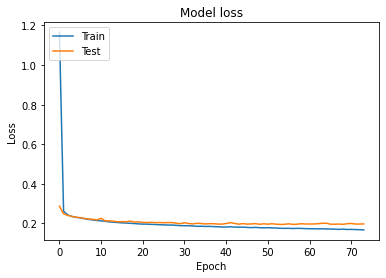

验证集上的最优结果是0.5204343795776367,对应训练轮次是54


0.5204343795776367

In [23]:

train_DNN(X_train,y_train,X_test,y_test)

In [28]:
# 参数调节
import tensorflow as tf
lr_list = [1,0.1,0.01,0.001,0.0001]

optimizer_list = []
for i in lr_list:
    optimizer_list.append(tf.keras.optimizers.SGD(learning_rate=i))
    optimizer_list.append(tf.keras.optimizers.Adagrad(learning_rate=i))
    optimizer_list.append(tf.keras.optimizers.Adadelta(learning_rate=i))
    optimizer_list.append(tf.keras.optimizers.Adam(learning_rate=i))

hidden_layer_num_list=[1,2,3,4,5,6,7,8]
hidden_layer_units_list=[512,256,128,64,32,16]
batch_size_list=[512,256,128,64]
hidden_layer_dropout_list = [True,False]
input_layer_dropout_list = [True,False]
dropout_rate_list = [0.1,0.2,0.3,0.4,0.5]
use_kernel_regularizer_list = [True,False]
re_cof_list = [1,0.1,0.01,0.001,0.0001,0.00001,0.000001]
kernel_regularizer_list = []
for i in re_cof_list:
    kernel_regularizer_list.append(tf.keras.regularizers.l1(i))
    kernel_regularizer_list.append(tf.keras.regularizers.l2(i))





create model. feature_dim =2028, label_dim =151
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 512)               1038848   
                                                                 
 dense_14 (Dense)            (None, 512)               262656    
                                                                 
 dense_15 (Dense)            (None, 151)               77463     
                                                                 
Total params: 1,378,967
Trainable params: 1,378,967
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 13ms/step - loss: 1.0113 - JI: 0.3431 - val_loss: 0.3025 - val_JI: 0.3829
Epoch 2/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2688 - JI: 0.4075 - val_loss: 0.2614 - val_JI: 0.4130


Epoch 57/500
50/50 [==============================] - 1s 13ms/step - loss: 0.1613 - JI: 0.5838 - val_loss: 0.2005 - val_JI: 0.5109
Epoch 58/500
50/50 [==============================] - 1s 14ms/step - loss: 0.1600 - JI: 0.5866 - val_loss: 0.1977 - val_JI: 0.5193
Epoch 59/500
50/50 [==============================] - 1s 13ms/step - loss: 0.1583 - JI: 0.5898 - val_loss: 0.1995 - val_JI: 0.5111
Epoch 60/500
50/50 [==============================] - 1s 13ms/step - loss: 0.1594 - JI: 0.5885 - val_loss: 0.2005 - val_JI: 0.5079
Epoch 61/500
50/50 [==============================] - 1s 13ms/step - loss: 0.1572 - JI: 0.5915 - val_loss: 0.1971 - val_JI: 0.5169
Epoch 62/500
50/50 [==============================] - 1s 12ms/step - loss: 0.1562 - JI: 0.5939 - val_loss: 0.1981 - val_JI: 0.5161


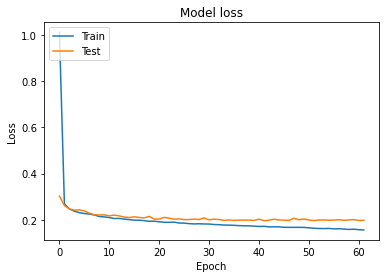

验证集上的最优结果是0.5192975401878357,对应训练轮次是58
create model. feature_dim =2028, label_dim =151
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               519424    
                                                                 
 dense_17 (Dense)            (None, 256)               65792     
                                                                 
 dense_18 (Dense)            (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 19ms/step - loss: 1.3749 - JI: 0.3221 - val_loss: 0.3028 - val_JI: 0.3800
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2726 - JI: 0.4018 - 

50/50 [==============================] - 0s 7ms/step - loss: 0.1735 - JI: 0.5582 - val_loss: 0.1952 - val_JI: 0.5153
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1727 - JI: 0.5603 - val_loss: 0.1932 - val_JI: 0.5196
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1725 - JI: 0.5599 - val_loss: 0.1965 - val_JI: 0.5169
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1720 - JI: 0.5613 - val_loss: 0.1933 - val_JI: 0.5188
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1702 - JI: 0.5645 - val_loss: 0.1979 - val_JI: 0.5158
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1705 - JI: 0.5638 - val_loss: 0.1940 - val_JI: 0.5190
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1714 - JI: 0.5621 - val_loss: 0.1966 - val_JI: 0.5092
Epoch 64/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1699 - JI: 0.5657 - val_los

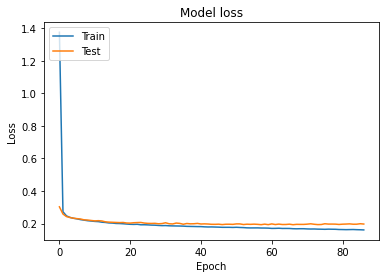

验证集上的最优结果是0.5215494632720947,对应训练轮次是79
create model. feature_dim =2028, label_dim =151
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               259712    
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dense_21 (Dense)            (None, 151)               19479     
                                                                 
Total params: 295,703
Trainable params: 295,703
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 7ms/step - loss: 1.5154 - JI: 0.2754 - val_loss: 0.2779 - val_JI: 0.3898
Epoch 2/500
50/50 [==============================] - 0s 5ms/step - loss: 0.2579 - JI: 0.4071 - v

50/50 [==============================] - 0s 4ms/step - loss: 0.1814 - JI: 0.5409 - val_loss: 0.1989 - val_JI: 0.5096
Epoch 58/500
50/50 [==============================] - 0s 4ms/step - loss: 0.1809 - JI: 0.5424 - val_loss: 0.1973 - val_JI: 0.5104
Epoch 59/500
50/50 [==============================] - 0s 4ms/step - loss: 0.1816 - JI: 0.5400 - val_loss: 0.1956 - val_JI: 0.5130
Epoch 60/500
50/50 [==============================] - 0s 4ms/step - loss: 0.1811 - JI: 0.5419 - val_loss: 0.2019 - val_JI: 0.5059
Epoch 61/500
50/50 [==============================] - 0s 4ms/step - loss: 0.1819 - JI: 0.5403 - val_loss: 0.1999 - val_JI: 0.5106
Epoch 62/500
50/50 [==============================] - 0s 4ms/step - loss: 0.1815 - JI: 0.5402 - val_loss: 0.1964 - val_JI: 0.5110
Epoch 63/500
50/50 [==============================] - 0s 5ms/step - loss: 0.1798 - JI: 0.5435 - val_loss: 0.1972 - val_JI: 0.5114
Epoch 64/500
50/50 [==============================] - 0s 4ms/step - loss: 0.1797 - JI: 0.5440 - val_los

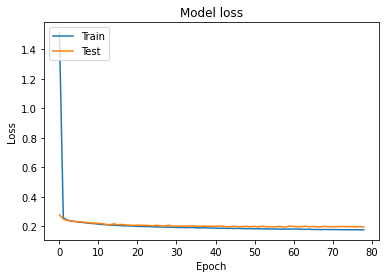

验证集上的最优结果是0.5183085203170776,对应训练轮次是72
create model. feature_dim =2028, label_dim =151
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 64)                129856    
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dense_24 (Dense)            (None, 151)               9815      
                                                                 
Total params: 143,831
Trainable params: 143,831
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 6ms/step - loss: 2.1491 - JI: 0.2278 - val_loss: 0.3267 - val_JI: 0.3417
Epoch 2/500
50/50 [==============================] - 0s 4ms/step - loss: 0.2828 - JI: 0.3910 - v

50/50 [==============================] - 0s 4ms/step - loss: 0.1892 - JI: 0.5265 - val_loss: 0.1971 - val_JI: 0.5069
Epoch 58/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1878 - JI: 0.5294 - val_loss: 0.1965 - val_JI: 0.5071
Epoch 59/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1871 - JI: 0.5310 - val_loss: 0.1978 - val_JI: 0.5058
Epoch 60/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1868 - JI: 0.5316 - val_loss: 0.1959 - val_JI: 0.5093
Epoch 61/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1865 - JI: 0.5320 - val_loss: 0.1965 - val_JI: 0.5098
Epoch 62/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1859 - JI: 0.5335 - val_loss: 0.1980 - val_JI: 0.5022
Epoch 63/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1860 - JI: 0.5331 - val_loss: 0.1962 - val_JI: 0.5118
Epoch 64/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1860 - JI: 0.5333 - val_los

Epoch 120/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1751 - JI: 0.5537 - val_loss: 0.1940 - val_JI: 0.5184
Epoch 121/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1750 - JI: 0.5540 - val_loss: 0.1935 - val_JI: 0.5165
Epoch 122/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1748 - JI: 0.5544 - val_loss: 0.1968 - val_JI: 0.5131
Epoch 123/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1755 - JI: 0.5526 - val_loss: 0.1969 - val_JI: 0.5057


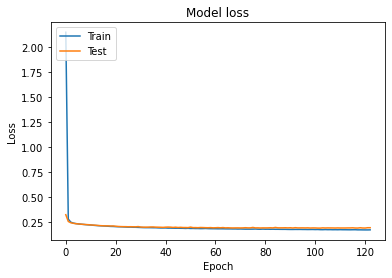

验证集上的最优结果是0.5184354782104492,对应训练轮次是120
create model. feature_dim =2028, label_dim =151
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 32)                64928     
                                                                 
 dense_26 (Dense)            (None, 32)                1056      
                                                                 
 dense_27 (Dense)            (None, 151)               4983      
                                                                 
Total params: 70,967
Trainable params: 70,967
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 5ms/step - loss: 1.5538 - JI: 0.1707 - val_loss: 0.3976 - val_JI: 0.2473
Epoch 2/500
50/50 [==============================] - 0s 4ms/step - loss: 0.2950 - JI: 0.3656 - va

50/50 [==============================] - 0s 3ms/step - loss: 0.2085 - JI: 0.4806 - val_loss: 0.2120 - val_JI: 0.4712
Epoch 58/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2082 - JI: 0.4810 - val_loss: 0.2118 - val_JI: 0.4722
Epoch 59/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2080 - JI: 0.4819 - val_loss: 0.2120 - val_JI: 0.4698
Epoch 60/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2082 - JI: 0.4810 - val_loss: 0.2124 - val_JI: 0.4710
Epoch 61/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2081 - JI: 0.4815 - val_loss: 0.2124 - val_JI: 0.4683
Epoch 62/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2089 - JI: 0.4794 - val_loss: 0.2125 - val_JI: 0.4710
Epoch 63/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2082 - JI: 0.4807 - val_loss: 0.2125 - val_JI: 0.4702
Epoch 64/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2078 - JI: 0.4820 - val_los

Epoch 120/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2032 - JI: 0.4899 - val_loss: 0.2081 - val_JI: 0.4764
Epoch 121/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2030 - JI: 0.4905 - val_loss: 0.2088 - val_JI: 0.4735
Epoch 122/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2033 - JI: 0.4895 - val_loss: 0.2082 - val_JI: 0.4763
Epoch 123/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2030 - JI: 0.4906 - val_loss: 0.2086 - val_JI: 0.4775
Epoch 124/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2030 - JI: 0.4903 - val_loss: 0.2089 - val_JI: 0.4738
Epoch 125/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2031 - JI: 0.4901 - val_loss: 0.2092 - val_JI: 0.4733
Epoch 126/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2031 - JI: 0.4902 - val_loss: 0.2083 - val_JI: 0.4744
Epoch 127/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2034 -

50/50 [==============================] - 0s 3ms/step - loss: 0.1997 - JI: 0.4968 - val_loss: 0.2065 - val_JI: 0.4832
Epoch 183/500
50/50 [==============================] - 0s 4ms/step - loss: 0.1994 - JI: 0.4973 - val_loss: 0.2064 - val_JI: 0.4787
Epoch 184/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1993 - JI: 0.4975 - val_loss: 0.2073 - val_JI: 0.4767
Epoch 185/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1993 - JI: 0.4974 - val_loss: 0.2078 - val_JI: 0.4775
Epoch 186/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1997 - JI: 0.4969 - val_loss: 0.2069 - val_JI: 0.4777
Epoch 187/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1995 - JI: 0.4970 - val_loss: 0.2059 - val_JI: 0.4834
Epoch 188/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1993 - JI: 0.4973 - val_loss: 0.2067 - val_JI: 0.4815
Epoch 189/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1991 - JI: 0.4979 - 

50/50 [==============================] - 0s 3ms/step - loss: 0.1977 - JI: 0.5008 - val_loss: 0.2054 - val_JI: 0.4839
Epoch 245/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1972 - JI: 0.5013 - val_loss: 0.2057 - val_JI: 0.4848
Epoch 246/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1970 - JI: 0.5023 - val_loss: 0.2055 - val_JI: 0.4837
Epoch 247/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1972 - JI: 0.5015 - val_loss: 0.2063 - val_JI: 0.4819
Epoch 248/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1974 - JI: 0.5014 - val_loss: 0.2068 - val_JI: 0.4838
Epoch 249/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1975 - JI: 0.5010 - val_loss: 0.2054 - val_JI: 0.4825
Epoch 250/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1970 - JI: 0.5014 - val_loss: 0.2059 - val_JI: 0.4816
Epoch 251/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1970 - JI: 0.5022 - 

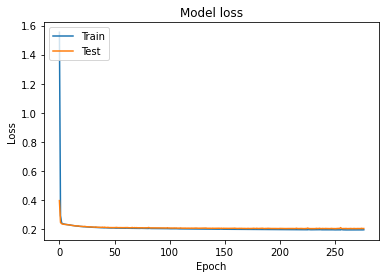

验证集上的最优结果是0.48583897948265076,对应训练轮次是241
create model. feature_dim =2028, label_dim =151
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 16)                32464     
                                                                 
 dense_29 (Dense)            (None, 16)                272       
                                                                 
 dense_30 (Dense)            (None, 151)               2567      
                                                                 
Total params: 35,303
Trainable params: 35,303
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 5ms/step - loss: 1.4238 - JI: 0.1393 - val_loss: 0.5969 - val_JI: 0.1543
Epoch 2/500
50/50 [==============================] - 0s 3ms/step - loss: 0.4581 - JI: 0.2228 - v

50/50 [==============================] - 0s 3ms/step - loss: 0.2115 - JI: 0.4730 - val_loss: 0.2166 - val_JI: 0.4616
Epoch 58/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2114 - JI: 0.4737 - val_loss: 0.2147 - val_JI: 0.4648
Epoch 59/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2110 - JI: 0.4750 - val_loss: 0.2139 - val_JI: 0.4663
Epoch 60/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2109 - JI: 0.4750 - val_loss: 0.2138 - val_JI: 0.4654
Epoch 61/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2110 - JI: 0.4744 - val_loss: 0.2138 - val_JI: 0.4652
Epoch 62/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2111 - JI: 0.4740 - val_loss: 0.2143 - val_JI: 0.4657
Epoch 63/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2112 - JI: 0.4742 - val_loss: 0.2142 - val_JI: 0.4639
Epoch 64/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2108 - JI: 0.4747 - val_los

Epoch 120/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2079 - JI: 0.4798 - val_loss: 0.2118 - val_JI: 0.4690
Epoch 121/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2077 - JI: 0.4809 - val_loss: 0.2119 - val_JI: 0.4690
Epoch 122/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2075 - JI: 0.4810 - val_loss: 0.2125 - val_JI: 0.4653
Epoch 123/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2077 - JI: 0.4802 - val_loss: 0.2122 - val_JI: 0.4674
Epoch 124/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2077 - JI: 0.4803 - val_loss: 0.2118 - val_JI: 0.4682
Epoch 125/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2074 - JI: 0.4809 - val_loss: 0.2118 - val_JI: 0.4702
Epoch 126/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2077 - JI: 0.4805 - val_loss: 0.2146 - val_JI: 0.4598
Epoch 127/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2081 -

50/50 [==============================] - 0s 3ms/step - loss: 0.2051 - JI: 0.4858 - val_loss: 0.2102 - val_JI: 0.4721
Epoch 183/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2053 - JI: 0.4853 - val_loss: 0.2105 - val_JI: 0.4734
Epoch 184/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2054 - JI: 0.4854 - val_loss: 0.2102 - val_JI: 0.4733
Epoch 185/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2052 - JI: 0.4862 - val_loss: 0.2101 - val_JI: 0.4733
Epoch 186/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2053 - JI: 0.4858 - val_loss: 0.2107 - val_JI: 0.4726
Epoch 187/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2057 - JI: 0.4843 - val_loss: 0.2107 - val_JI: 0.4708
Epoch 188/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2053 - JI: 0.4854 - val_loss: 0.2104 - val_JI: 0.4718
Epoch 189/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2051 - JI: 0.4856 - 

50/50 [==============================] - 0s 3ms/step - loss: 0.2011 - JI: 0.4934 - val_loss: 0.2077 - val_JI: 0.4790
Epoch 245/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2014 - JI: 0.4926 - val_loss: 0.2087 - val_JI: 0.4731
Epoch 246/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2012 - JI: 0.4939 - val_loss: 0.2071 - val_JI: 0.4810
Epoch 247/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2003 - JI: 0.4951 - val_loss: 0.2071 - val_JI: 0.4800
Epoch 248/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2011 - JI: 0.4937 - val_loss: 0.2074 - val_JI: 0.4763
Epoch 249/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2005 - JI: 0.4952 - val_loss: 0.2068 - val_JI: 0.4786
Epoch 250/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2004 - JI: 0.4952 - val_loss: 0.2078 - val_JI: 0.4744
Epoch 251/500
50/50 [==============================] - 0s 3ms/step - loss: 0.2006 - JI: 0.4943 - 

50/50 [==============================] - 0s 3ms/step - loss: 0.1987 - JI: 0.4993 - val_loss: 0.2075 - val_JI: 0.4789
Epoch 307/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1991 - JI: 0.4980 - val_loss: 0.2061 - val_JI: 0.4824
Epoch 308/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1989 - JI: 0.4990 - val_loss: 0.2074 - val_JI: 0.4794
Epoch 309/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1990 - JI: 0.4983 - val_loss: 0.2068 - val_JI: 0.4804
Epoch 310/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1987 - JI: 0.4989 - val_loss: 0.2062 - val_JI: 0.4815
Epoch 311/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1985 - JI: 0.4991 - val_loss: 0.2070 - val_JI: 0.4807
Epoch 312/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1988 - JI: 0.4991 - val_loss: 0.2063 - val_JI: 0.4822
Epoch 313/500
50/50 [==============================] - 0s 3ms/step - loss: 0.1987 - JI: 0.4991 - 

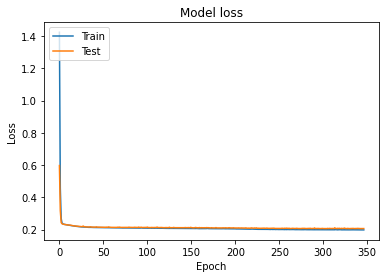

验证集上的最优结果是0.4827938973903656,对应训练轮次是345


[0.5192975401878357,
 0.5215494632720947,
 0.5183085203170776,
 0.5184354782104492,
 0.48583897948265076,
 0.4827938973903656]

In [29]:
# 调节隐层单元数
result_list = []
for i in hidden_layer_units_list:
    result_list.append(train_DNN(X_train,y_train,X_test,y_test,hidden_layer_units=i))
result_list

create model. feature_dim =2028, label_dim =151
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 256)               519424    
                                                                 
 dense_35 (Dense)            (None, 256)               65792     
                                                                 
 dense_36 (Dense)            (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 8ms/step - loss: 1.2190 - JI: 0.3308 - val_loss: 0.2942 - val_JI: 0.3778
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2670 - JI: 0.4053 - val_loss: 0.2515 - val_JI: 0.4102
Epoch

50/50 [==============================] - 0s 7ms/step - loss: 0.1725 - JI: 0.5601 - val_loss: 0.2003 - val_JI: 0.4989
Epoch 58/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1721 - JI: 0.5606 - val_loss: 0.1942 - val_JI: 0.5180
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1701 - JI: 0.5641 - val_loss: 0.1963 - val_JI: 0.5194
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1708 - JI: 0.5630 - val_loss: 0.1936 - val_JI: 0.5212
Epoch 61/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1703 - JI: 0.5641 - val_loss: 0.1960 - val_JI: 0.5116
Epoch 62/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1698 - JI: 0.5655 - val_loss: 0.2006 - val_JI: 0.5001
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1711 - JI: 0.5629 - val_loss: 0.1961 - val_JI: 0.5147
Epoch 64/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1688 - JI: 0.5672 - val_los

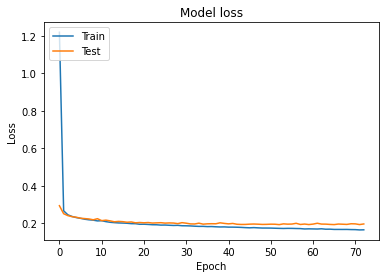

验证集上的最优结果是0.5211640000343323,对应训练轮次是68
create model. feature_dim =2028, label_dim =151
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 256)               519424    
                                                                 
 dense_38 (Dense)            (None, 256)               65792     
                                                                 
 dense_39 (Dense)            (None, 256)               65792     
                                                                 
 dense_40 (Dense)            (None, 151)               38807     
                                                                 
Total params: 689,815
Trainable params: 689,815
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 10ms/step - loss: 0.6517 - JI: 0.349

50/50 [==============================] - 0s 7ms/step - loss: 0.1696 - JI: 0.5633 - val_loss: 0.1965 - val_JI: 0.5147
Epoch 57/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1686 - JI: 0.5662 - val_loss: 0.1994 - val_JI: 0.5149
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1676 - JI: 0.5681 - val_loss: 0.1963 - val_JI: 0.5103
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1661 - JI: 0.5707 - val_loss: 0.1962 - val_JI: 0.5115
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1669 - JI: 0.5701 - val_loss: 0.1989 - val_JI: 0.5113
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1662 - JI: 0.5710 - val_loss: 0.1994 - val_JI: 0.5147
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1662 - JI: 0.5706 - val_loss: 0.1959 - val_JI: 0.5179


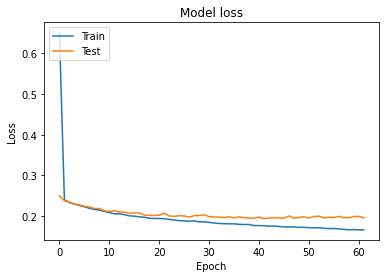

验证集上的最优结果是0.5178824067115784,对应训练轮次是62
create model. feature_dim =2028, label_dim =151
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 256)               519424    
                                                                 
 dense_42 (Dense)            (None, 256)               65792     
                                                                 
 dense_43 (Dense)            (None, 256)               65792     
                                                                 
 dense_44 (Dense)            (None, 256)               65792     
                                                                 
 dense_45 (Dense)            (None, 151)               38807     
                                                                 
Total params: 755,607
Trainable params: 755,607
Non-trainable params: 0
__________________________

50/50 [==============================] - 0s 7ms/step - loss: 0.1692 - JI: 0.5638 - val_loss: 0.1969 - val_JI: 0.5151
Epoch 56/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1689 - JI: 0.5642 - val_loss: 0.1988 - val_JI: 0.5099
Epoch 57/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1695 - JI: 0.5634 - val_loss: 0.1994 - val_JI: 0.5063
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1679 - JI: 0.5673 - val_loss: 0.1987 - val_JI: 0.5125
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1670 - JI: 0.5685 - val_loss: 0.1979 - val_JI: 0.5115
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1665 - JI: 0.5696 - val_loss: 0.1965 - val_JI: 0.5180
Epoch 61/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1659 - JI: 0.5707 - val_loss: 0.1991 - val_JI: 0.5135
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1648 - JI: 0.5737 - val_los

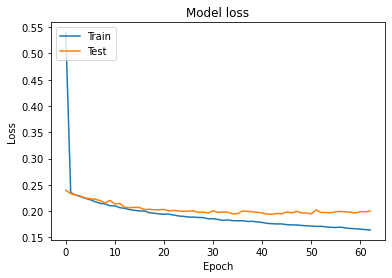

验证集上的最优结果是0.5179943442344666,对应训练轮次是60
create model. feature_dim =2028, label_dim =151
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 256)               519424    
                                                                 
 dense_47 (Dense)            (None, 256)               65792     
                                                                 
 dense_48 (Dense)            (None, 256)               65792     
                                                                 
 dense_49 (Dense)            (None, 256)               65792     
                                                                 
 dense_50 (Dense)            (None, 256)               65792     
                                                                 
 dense_51 (Dense)            (None, 151)               38807     
                                

Epoch 54/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1685 - JI: 0.5650 - val_loss: 0.2019 - val_JI: 0.5078
Epoch 55/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1702 - JI: 0.5620 - val_loss: 0.2027 - val_JI: 0.4940
Epoch 56/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1680 - JI: 0.5669 - val_loss: 0.1984 - val_JI: 0.5064
Epoch 57/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1659 - JI: 0.5707 - val_loss: 0.1985 - val_JI: 0.5037
Epoch 58/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1659 - JI: 0.5702 - val_loss: 0.1987 - val_JI: 0.5100
Epoch 59/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1644 - JI: 0.5728 - val_loss: 0.1981 - val_JI: 0.5123
Epoch 60/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1631 - JI: 0.5764 - val_loss: 0.1998 - val_JI: 0.5016
Epoch 61/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1628 - JI: 0.

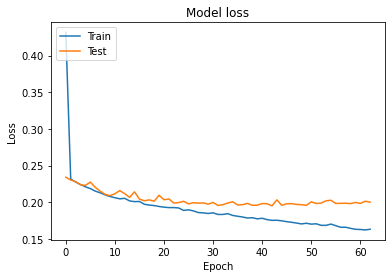

验证集上的最优结果是0.5145808458328247,对应训练轮次是46
create model. feature_dim =2028, label_dim =151
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 256)               519424    
                                                                 
 dense_53 (Dense)            (None, 256)               65792     
                                                                 
 dense_54 (Dense)            (None, 256)               65792     
                                                                 
 dense_55 (Dense)            (None, 256)               65792     
                                                                 
 dense_56 (Dense)            (None, 256)               65792     
                                                                 
 dense_57 (Dense)            (None, 256)               65792     
                                

50/50 [==============================] - 0s 8ms/step - loss: 0.1685 - JI: 0.5643 - val_loss: 0.2007 - val_JI: 0.5001


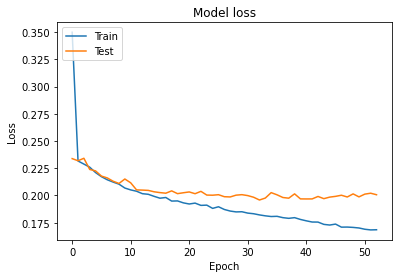

验证集上的最优结果是0.5118333697319031,对应训练轮次是44
create model. feature_dim =2028, label_dim =151
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 256)               519424    
                                                                 
 dense_60 (Dense)            (None, 256)               65792     
                                                                 
 dense_61 (Dense)            (None, 256)               65792     
                                                                 
 dense_62 (Dense)            (None, 256)               65792     
                                                                 
 dense_63 (Dense)            (None, 256)               65792     
                                                                 
 dense_64 (Dense)            (None, 256)               65792     
                                

50/50 [==============================] - 0s 9ms/step - loss: 0.1679 - JI: 0.5657 - val_loss: 0.2020 - val_JI: 0.4990
Epoch 53/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1686 - JI: 0.5638 - val_loss: 0.2055 - val_JI: 0.5053
Epoch 54/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1682 - JI: 0.5645 - val_loss: 0.2018 - val_JI: 0.5055
Epoch 55/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1658 - JI: 0.5695 - val_loss: 0.2039 - val_JI: 0.4975


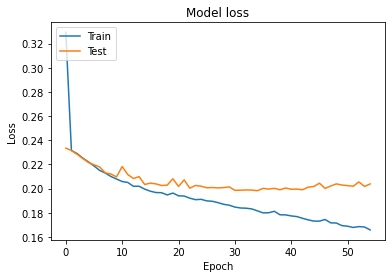

验证集上的最优结果是0.5089823603630066,对应训练轮次是50
create model. feature_dim =2028, label_dim =151
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 256)               519424    
                                                                 
 dense_68 (Dense)            (None, 256)               65792     
                                                                 
 dense_69 (Dense)            (None, 256)               65792     
                                                                 
 dense_70 (Dense)            (None, 256)               65792     
                                                                 
 dense_71 (Dense)            (None, 256)               65792     
                                                                 
 dense_72 (Dense)            (None, 256)               65792     
                                

Epoch 51/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1744 - JI: 0.5508 - val_loss: 0.2000 - val_JI: 0.5008
Epoch 52/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1731 - JI: 0.5533 - val_loss: 0.2006 - val_JI: 0.4990
Epoch 53/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1729 - JI: 0.5542 - val_loss: 0.2037 - val_JI: 0.4901
Epoch 54/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1716 - JI: 0.5557 - val_loss: 0.2010 - val_JI: 0.5038
Epoch 55/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1699 - JI: 0.5603 - val_loss: 0.2030 - val_JI: 0.5031
Epoch 56/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1700 - JI: 0.5604 - val_loss: 0.2020 - val_JI: 0.4965
Epoch 57/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1685 - JI: 0.5630 - val_loss: 0.2068 - val_JI: 0.4888
Epoch 58/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1680 - JI: 0.5

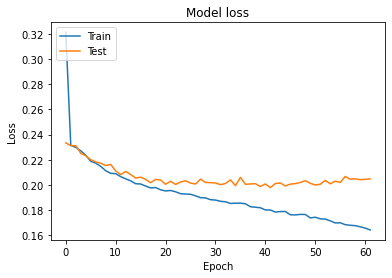

验证集上的最优结果是0.5037772059440613,对应训练轮次是54
create model. feature_dim =2028, label_dim =151
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 256)               519424    
                                                                 
 dense_77 (Dense)            (None, 256)               65792     
                                                                 
 dense_78 (Dense)            (None, 256)               65792     
                                                                 
 dense_79 (Dense)            (None, 256)               65792     
                                                                 
 dense_80 (Dense)            (None, 256)               65792     
                                                                 
 dense_81 (Dense)            (None, 256)               65792     
                                

50/50 [==============================] - 1s 10ms/step - loss: 0.1769 - JI: 0.5456 - val_loss: 0.2019 - val_JI: 0.4947
Epoch 50/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1736 - JI: 0.5524 - val_loss: 0.2005 - val_JI: 0.5038
Epoch 51/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1728 - JI: 0.5535 - val_loss: 0.2013 - val_JI: 0.5032
Epoch 52/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1710 - JI: 0.5576 - val_loss: 0.2024 - val_JI: 0.4946


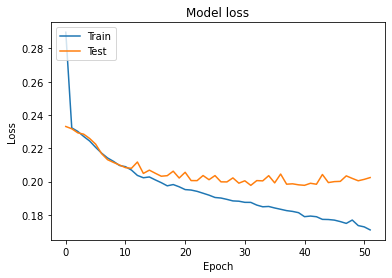

验证集上的最优结果是0.5045888423919678,对应训练轮次是41


[0.5211640000343323,
 0.5178824067115784,
 0.5179943442344666,
 0.5145808458328247,
 0.5118333697319031,
 0.5089823603630066,
 0.5037772059440613,
 0.5045888423919678]

In [31]:
# 调节隐层层数
result_list = []
for i in hidden_layer_num_list:
    result_list.append(train_DNN(X_train,y_train,X_test,y_test,hidden_layer_num=i))
result_list

create model. feature_dim =2028, label_dim =151
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_86 (Dense)            (None, 256)               519424    
                                                                 
 dense_87 (Dense)            (None, 256)               65792     
                                                                 
 dense_88 (Dense)            (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 2215.2122 - JI: 0.3277 - val_loss: 1052.2727 - val_JI: 0.3861
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 443.2120 - JI: 0.3955 - val_loss: 53.4567 - val_JI: 0.3

50/50 [==============================] - 0s 7ms/step - loss: 7.6565 - JI: 0.4297 - val_loss: 7.6533 - val_JI: 0.4242
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 7.6455 - JI: 0.4295 - val_loss: 7.6650 - val_JI: 0.4234
Epoch 59/500
50/50 [==============================] - 0s 6ms/step - loss: 7.6372 - JI: 0.4287 - val_loss: 7.6931 - val_JI: 0.4256
Epoch 60/500
50/50 [==============================] - 0s 6ms/step - loss: 7.6478 - JI: 0.4292 - val_loss: 7.6641 - val_JI: 0.4245
Epoch 61/500
50/50 [==============================] - 0s 6ms/step - loss: 7.6363 - JI: 0.4293 - val_loss: 7.6680 - val_JI: 0.4251
Epoch 62/500
50/50 [==============================] - 0s 6ms/step - loss: 7.6388 - JI: 0.4291 - val_loss: 7.6328 - val_JI: 0.4252
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 7.6379 - JI: 0.4291 - val_loss: 7.6540 - val_JI: 0.4244
Epoch 64/500
50/50 [==============================] - 0s 6ms/step - loss: 7.6347 - JI: 0.4294 - val_los

Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 7.5502 - JI: 0.4296 - val_loss: 7.5624 - val_JI: 0.4253
Epoch 121/500
50/50 [==============================] - 0s 6ms/step - loss: 7.5477 - JI: 0.4296 - val_loss: 7.5426 - val_JI: 0.4252
Epoch 122/500
50/50 [==============================] - 0s 6ms/step - loss: 7.5562 - JI: 0.4298 - val_loss: 7.5268 - val_JI: 0.4250
Epoch 123/500
50/50 [==============================] - 0s 6ms/step - loss: 7.5602 - JI: 0.4295 - val_loss: 7.5533 - val_JI: 0.4255
Epoch 124/500
50/50 [==============================] - 0s 6ms/step - loss: 7.5478 - JI: 0.4296 - val_loss: 7.5588 - val_JI: 0.4252
Epoch 125/500
50/50 [==============================] - 0s 6ms/step - loss: 7.5506 - JI: 0.4294 - val_loss: 7.5696 - val_JI: 0.4249
Epoch 126/500
50/50 [==============================] - 0s 6ms/step - loss: 7.5479 - JI: 0.4300 - val_loss: 7.5715 - val_JI: 0.4227
Epoch 127/500
50/50 [==============================] - 0s 6ms/step - loss: 7.5510 -

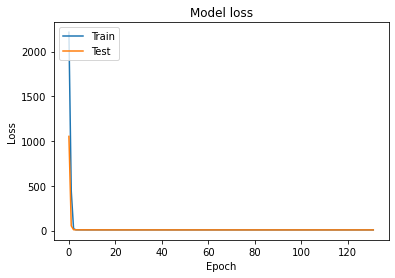

验证集上的最优结果是0.42576614022254944,对应训练轮次是93
create model. feature_dim =2028, label_dim =151
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_89 (Dense)            (None, 256)               519424    
                                                                 
 dense_90 (Dense)            (None, 256)               65792     
                                                                 
 dense_91 (Dense)            (None, 256)               65792     
                                                                 
 dense_92 (Dense)            (None, 256)               65792     
                                                                 
 dense_93 (Dense)            (None, 256)               65792     
                                                                 
 dense_94 (Dense)            (None, 151)               38807     
                               

50/50 [==============================] - 0s 8ms/step - loss: 33.0656 - JI: 0.4295 - val_loss: 32.9004 - val_JI: 0.4252
Epoch 54/500
50/50 [==============================] - 0s 8ms/step - loss: 33.0805 - JI: 0.4296 - val_loss: 33.1430 - val_JI: 0.4252


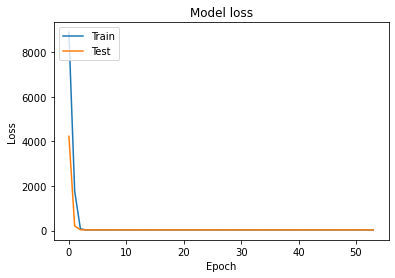

验证集上的最优结果是0.425189346075058,对应训练轮次是3
create model. feature_dim =2028, label_dim =151
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_95 (Dense)            (None, 256)               519424    
                                                                 
 dense_96 (Dense)            (None, 256)               65792     
                                                                 
 dense_97 (Dense)            (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 8ms/step - loss: 138.8189 - JI: 0.3368 - val_loss: 53.6114 - val_JI: 0.3977
Epoch 2/500
50/50 [==============================] - 0s 6ms/step - loss: 25.0161 - JI: 0.4208 

50/50 [==============================] - 0s 6ms/step - loss: 0.2198 - JI: 0.4673 - val_loss: 0.2196 - val_JI: 0.4579
Epoch 58/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2180 - JI: 0.4680 - val_loss: 0.2197 - val_JI: 0.4606
Epoch 59/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2182 - JI: 0.4682 - val_loss: 0.2195 - val_JI: 0.4596
Epoch 60/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2178 - JI: 0.4688 - val_loss: 0.2186 - val_JI: 0.4621
Epoch 61/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2173 - JI: 0.4700 - val_loss: 0.2191 - val_JI: 0.4619
Epoch 62/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2173 - JI: 0.4706 - val_loss: 0.2178 - val_JI: 0.4620
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2169 - JI: 0.4706 - val_loss: 0.2186 - val_JI: 0.4603
Epoch 64/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2173 - JI: 0.4712 - val_los

Epoch 120/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2062 - JI: 0.4920 - val_loss: 0.2102 - val_JI: 0.4776
Epoch 121/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2067 - JI: 0.4912 - val_loss: 0.2091 - val_JI: 0.4817
Epoch 122/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2054 - JI: 0.4932 - val_loss: 0.2084 - val_JI: 0.4845
Epoch 123/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2053 - JI: 0.4939 - val_loss: 0.2087 - val_JI: 0.4838
Epoch 124/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2050 - JI: 0.4947 - val_loss: 0.2091 - val_JI: 0.4851
Epoch 125/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2055 - JI: 0.4928 - val_loss: 0.2082 - val_JI: 0.4849
Epoch 126/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2054 - JI: 0.4940 - val_loss: 0.2081 - val_JI: 0.4827
Epoch 127/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2048 -

50/50 [==============================] - 0s 6ms/step - loss: 0.2012 - JI: 0.5021 - val_loss: 0.2060 - val_JI: 0.4870
Epoch 183/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2011 - JI: 0.5019 - val_loss: 0.2052 - val_JI: 0.4905
Epoch 184/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2009 - JI: 0.5022 - val_loss: 0.2060 - val_JI: 0.4889
Epoch 185/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2008 - JI: 0.5023 - val_loss: 0.2049 - val_JI: 0.4891
Epoch 186/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2010 - JI: 0.5019 - val_loss: 0.2051 - val_JI: 0.4901
Epoch 187/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2007 - JI: 0.5024 - val_loss: 0.2052 - val_JI: 0.4887
Epoch 188/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2005 - JI: 0.5037 - val_loss: 0.2055 - val_JI: 0.4906
Epoch 189/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2005 - JI: 0.5027 - 

50/50 [==============================] - 0s 6ms/step - loss: 0.1974 - JI: 0.5104 - val_loss: 0.2034 - val_JI: 0.4953
Epoch 245/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1972 - JI: 0.5106 - val_loss: 0.2040 - val_JI: 0.4928
Epoch 246/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1973 - JI: 0.5109 - val_loss: 0.2037 - val_JI: 0.4915
Epoch 247/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1975 - JI: 0.5104 - val_loss: 0.2041 - val_JI: 0.4924
Epoch 248/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1976 - JI: 0.5105 - val_loss: 0.2027 - val_JI: 0.4973
Epoch 249/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1975 - JI: 0.5103 - val_loss: 0.2042 - val_JI: 0.4915
Epoch 250/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1972 - JI: 0.5108 - val_loss: 0.2048 - val_JI: 0.4963
Epoch 251/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1972 - JI: 0.5111 - 

50/50 [==============================] - 0s 7ms/step - loss: 0.1942 - JI: 0.5194 - val_loss: 0.2046 - val_JI: 0.4897
Epoch 307/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1950 - JI: 0.5172 - val_loss: 0.2017 - val_JI: 0.5029
Epoch 308/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1942 - JI: 0.5188 - val_loss: 0.2018 - val_JI: 0.5019
Epoch 309/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1938 - JI: 0.5193 - val_loss: 0.2006 - val_JI: 0.5014
Epoch 310/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1937 - JI: 0.5198 - val_loss: 0.2011 - val_JI: 0.5023
Epoch 311/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1936 - JI: 0.5202 - val_loss: 0.2021 - val_JI: 0.5004
Epoch 312/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1936 - JI: 0.5195 - val_loss: 0.2012 - val_JI: 0.5027
Epoch 313/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1936 - JI: 0.5196 - 

50/50 [==============================] - 0s 6ms/step - loss: 0.1917 - JI: 0.5245 - val_loss: 0.1994 - val_JI: 0.5073
Epoch 369/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1918 - JI: 0.5246 - val_loss: 0.2002 - val_JI: 0.5024
Epoch 370/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1916 - JI: 0.5251 - val_loss: 0.2019 - val_JI: 0.4984
Epoch 371/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1918 - JI: 0.5239 - val_loss: 0.2008 - val_JI: 0.5079
Epoch 372/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1909 - JI: 0.5256 - val_loss: 0.2001 - val_JI: 0.5076
Epoch 373/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1913 - JI: 0.5253 - val_loss: 0.1992 - val_JI: 0.5093
Epoch 374/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1914 - JI: 0.5252 - val_loss: 0.1997 - val_JI: 0.5055
Epoch 375/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1910 - JI: 0.5256 - 

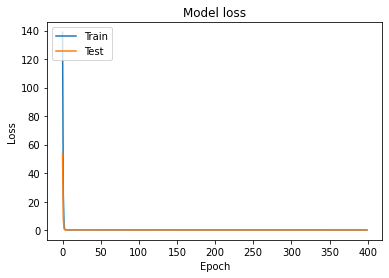

验证集上的最优结果是0.5099629759788513,对应训练轮次是396
create model. feature_dim =2028, label_dim =151
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_98 (Dense)            (None, 256)               519424    
                                                                 
 dense_99 (Dense)            (None, 256)               65792     
                                                                 
 dense_100 (Dense)           (None, 256)               65792     
                                                                 
 dense_101 (Dense)           (None, 256)               65792     
                                                                 
 dense_102 (Dense)           (None, 256)               65792     
                                                                 
 dense_103 (Dense)           (None, 151)               38807     
                               

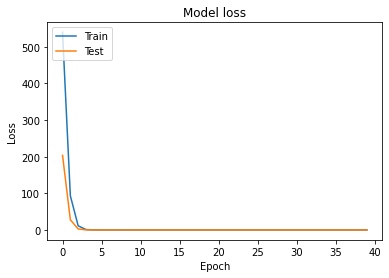

验证集上的最优结果是0.425189346075058,对应训练轮次是5
create model. feature_dim =2028, label_dim =151
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_104 (Dense)           (None, 256)               519424    
                                                                 
 dense_105 (Dense)           (None, 256)               65792     
                                                                 
 dense_106 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 228.6915 - JI: 0.3345 - val_loss: 112.8256 - val_JI: 0.3881
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 49.7877 - JI: 0.4098

50/50 [==============================] - 0s 6ms/step - loss: 0.9705 - JI: 0.4327 - val_loss: 0.9717 - val_JI: 0.4276
Epoch 58/500
50/50 [==============================] - 0s 6ms/step - loss: 0.9716 - JI: 0.4330 - val_loss: 0.9728 - val_JI: 0.4257
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.9720 - JI: 0.4334 - val_loss: 0.9714 - val_JI: 0.4281
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.9696 - JI: 0.4337 - val_loss: 0.9689 - val_JI: 0.4269
Epoch 61/500
50/50 [==============================] - 0s 6ms/step - loss: 0.9693 - JI: 0.4340 - val_loss: 0.9767 - val_JI: 0.4270
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.9691 - JI: 0.4341 - val_loss: 0.9717 - val_JI: 0.4284
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 0.9736 - JI: 0.4347 - val_loss: 0.9776 - val_JI: 0.4266
Epoch 64/500
50/50 [==============================] - 0s 6ms/step - loss: 0.9715 - JI: 0.4345 - val_los

Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.9481 - JI: 0.4476 - val_loss: 0.9566 - val_JI: 0.4402
Epoch 121/500
50/50 [==============================] - 0s 6ms/step - loss: 0.9511 - JI: 0.4476 - val_loss: 0.9531 - val_JI: 0.4369
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.9532 - JI: 0.4477 - val_loss: 0.9482 - val_JI: 0.4403
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.9452 - JI: 0.4482 - val_loss: 0.9555 - val_JI: 0.4405
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.9533 - JI: 0.4478 - val_loss: 0.9479 - val_JI: 0.4411
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.9472 - JI: 0.4486 - val_loss: 0.9545 - val_JI: 0.4415
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.9492 - JI: 0.4489 - val_loss: 0.9548 - val_JI: 0.4411
Epoch 127/500
50/50 [==============================] - 0s 6ms/step - loss: 0.9493 -

50/50 [==============================] - 0s 6ms/step - loss: 0.9250 - JI: 0.4620 - val_loss: 0.9345 - val_JI: 0.4556
Epoch 183/500
50/50 [==============================] - 0s 7ms/step - loss: 0.9291 - JI: 0.4620 - val_loss: 0.9320 - val_JI: 0.4555
Epoch 184/500
50/50 [==============================] - 0s 6ms/step - loss: 0.9267 - JI: 0.4626 - val_loss: 0.9261 - val_JI: 0.4559
Epoch 185/500
50/50 [==============================] - 0s 6ms/step - loss: 0.9256 - JI: 0.4629 - val_loss: 0.9327 - val_JI: 0.4565
Epoch 186/500
50/50 [==============================] - 0s 7ms/step - loss: 0.9259 - JI: 0.4631 - val_loss: 0.9254 - val_JI: 0.4545
Epoch 187/500
50/50 [==============================] - 0s 6ms/step - loss: 0.9262 - JI: 0.4628 - val_loss: 0.9302 - val_JI: 0.4556
Epoch 188/500
50/50 [==============================] - 0s 6ms/step - loss: 0.9260 - JI: 0.4633 - val_loss: 0.9238 - val_JI: 0.4566
Epoch 189/500
50/50 [==============================] - 0s 7ms/step - loss: 0.9255 - JI: 0.4632 - 

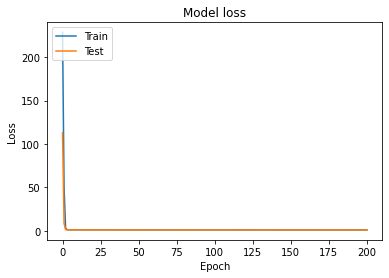

验证集上的最优结果是0.45900270342826843,对应训练轮次是199
create model. feature_dim =2028, label_dim =151
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_107 (Dense)           (None, 256)               519424    
                                                                 
 dense_108 (Dense)           (None, 256)               65792     
                                                                 
 dense_109 (Dense)           (None, 256)               65792     
                                                                 
 dense_110 (Dense)           (None, 256)               65792     
                                                                 
 dense_111 (Dense)           (None, 256)               65792     
                                                                 
 dense_112 (Dense)           (None, 151)               38807     
                              

Epoch 54/500
50/50 [==============================] - 0s 8ms/step - loss: 3.4590 - JI: 0.4296 - val_loss: 3.4647 - val_JI: 0.4244
Epoch 55/500
50/50 [==============================] - 0s 8ms/step - loss: 3.4574 - JI: 0.4294 - val_loss: 3.4556 - val_JI: 0.4252
Epoch 56/500
50/50 [==============================] - 0s 8ms/step - loss: 3.4573 - JI: 0.4296 - val_loss: 3.4627 - val_JI: 0.4252
Epoch 57/500
50/50 [==============================] - 0s 8ms/step - loss: 3.4592 - JI: 0.4295 - val_loss: 3.4642 - val_JI: 0.4252
Epoch 58/500
50/50 [==============================] - 0s 9ms/step - loss: 3.4589 - JI: 0.4297 - val_loss: 3.4564 - val_JI: 0.4252
Epoch 59/500
50/50 [==============================] - 0s 8ms/step - loss: 3.4582 - JI: 0.4295 - val_loss: 3.4574 - val_JI: 0.4252
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 3.4577 - JI: 0.4294 - val_loss: 3.4642 - val_JI: 0.4252
Epoch 61/500
50/50 [==============================] - 0s 8ms/step - loss: 3.4576 - JI: 0.4

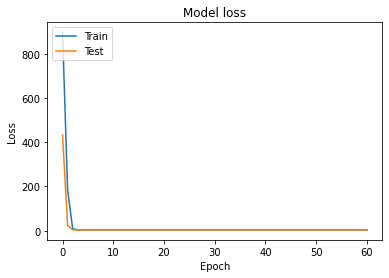

验证集上的最优结果是0.425189346075058,对应训练轮次是3
create model. feature_dim =2028, label_dim =151
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_113 (Dense)           (None, 256)               519424    
                                                                 
 dense_114 (Dense)           (None, 256)               65792     
                                                                 
 dense_115 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 16.7543 - JI: 0.3318 - val_loss: 8.4520 - val_JI: 0.3913
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 5.2566 - JI: 0.4150 - v

50/50 [==============================] - 0s 6ms/step - loss: 0.2086 - JI: 0.4889 - val_loss: 0.2100 - val_JI: 0.4805
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2076 - JI: 0.4897 - val_loss: 0.2098 - val_JI: 0.4836
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2067 - JI: 0.4915 - val_loss: 0.2101 - val_JI: 0.4779
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2072 - JI: 0.4902 - val_loss: 0.2112 - val_JI: 0.4724
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2062 - JI: 0.4924 - val_loss: 0.2095 - val_JI: 0.4788
Epoch 62/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2061 - JI: 0.4923 - val_loss: 0.2086 - val_JI: 0.4841
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2058 - JI: 0.4929 - val_loss: 0.2100 - val_JI: 0.4768
Epoch 64/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2056 - JI: 0.4929 - val_los

Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1978 - JI: 0.5088 - val_loss: 0.2033 - val_JI: 0.4948
Epoch 121/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1972 - JI: 0.5096 - val_loss: 0.2040 - val_JI: 0.4902
Epoch 122/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1971 - JI: 0.5097 - val_loss: 0.2031 - val_JI: 0.4965
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1973 - JI: 0.5091 - val_loss: 0.2048 - val_JI: 0.4868
Epoch 124/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1974 - JI: 0.5094 - val_loss: 0.2028 - val_JI: 0.4932
Epoch 125/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1967 - JI: 0.5106 - val_loss: 0.2035 - val_JI: 0.4956
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1968 - JI: 0.5107 - val_loss: 0.2028 - val_JI: 0.4929
Epoch 127/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1966 -

50/50 [==============================] - 0s 6ms/step - loss: 0.1911 - JI: 0.5249 - val_loss: 0.2002 - val_JI: 0.5061
Epoch 183/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1909 - JI: 0.5256 - val_loss: 0.1996 - val_JI: 0.5050
Epoch 184/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1912 - JI: 0.5245 - val_loss: 0.1999 - val_JI: 0.5053
Epoch 185/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1907 - JI: 0.5258 - val_loss: 0.1996 - val_JI: 0.5034
Epoch 186/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1906 - JI: 0.5265 - val_loss: 0.2000 - val_JI: 0.5063
Epoch 187/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1907 - JI: 0.5264 - val_loss: 0.2006 - val_JI: 0.5020
Epoch 188/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1904 - JI: 0.5264 - val_loss: 0.2000 - val_JI: 0.5065
Epoch 189/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1906 - JI: 0.5265 - 

50/50 [==============================] - 0s 6ms/step - loss: 0.1861 - JI: 0.5363 - val_loss: 0.1977 - val_JI: 0.5083
Epoch 245/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1860 - JI: 0.5366 - val_loss: 0.1971 - val_JI: 0.5128
Epoch 246/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1862 - JI: 0.5364 - val_loss: 0.1988 - val_JI: 0.5044
Epoch 247/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1862 - JI: 0.5357 - val_loss: 0.1975 - val_JI: 0.5109
Epoch 248/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1857 - JI: 0.5370 - val_loss: 0.1969 - val_JI: 0.5111
Epoch 249/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1859 - JI: 0.5363 - val_loss: 0.1986 - val_JI: 0.5097
Epoch 250/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1862 - JI: 0.5359 - val_loss: 0.1976 - val_JI: 0.5131
Epoch 251/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1856 - JI: 0.5371 - 

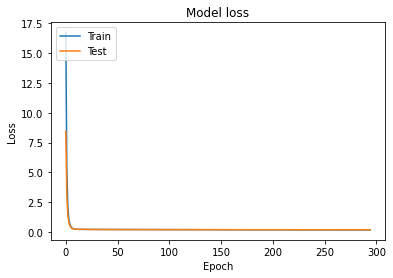

验证集上的最优结果是0.5163905024528503,对应训练轮次是276
create model. feature_dim =2028, label_dim =151
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (None, 256)               519424    
                                                                 
 dense_117 (Dense)           (None, 256)               65792     
                                                                 
 dense_118 (Dense)           (None, 256)               65792     
                                                                 
 dense_119 (Dense)           (None, 256)               65792     
                                                                 
 dense_120 (Dense)           (None, 256)               65792     
                                                                 
 dense_121 (Dense)           (None, 151)               38807     
                               

50/50 [==============================] - 0s 9ms/step - loss: 0.2323 - JI: 0.4296 - val_loss: 0.2326 - val_JI: 0.4252


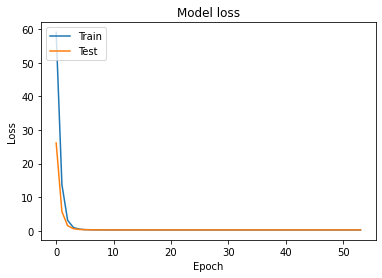

验证集上的最优结果是0.425189346075058,对应训练轮次是12
create model. feature_dim =2028, label_dim =151
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_122 (Dense)           (None, 256)               519424    
                                                                 
 dense_123 (Dense)           (None, 256)               65792     
                                                                 
 dense_124 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 25.7393 - JI: 0.3376 - val_loss: 15.1748 - val_JI: 0.3885
Epoch 2/500
50/50 [==============================] - 0s 6ms/step - loss: 9.3006 - JI: 0.4115 -

50/50 [==============================] - 0s 7ms/step - loss: 0.2986 - JI: 0.4492 - val_loss: 0.2988 - val_JI: 0.4412
Epoch 58/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2977 - JI: 0.4494 - val_loss: 0.2984 - val_JI: 0.4418
Epoch 59/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2972 - JI: 0.4504 - val_loss: 0.2987 - val_JI: 0.4437
Epoch 60/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2970 - JI: 0.4510 - val_loss: 0.3000 - val_JI: 0.4429
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2976 - JI: 0.4508 - val_loss: 0.2993 - val_JI: 0.4437
Epoch 62/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2968 - JI: 0.4522 - val_loss: 0.2988 - val_JI: 0.4432
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2976 - JI: 0.4520 - val_loss: 0.2972 - val_JI: 0.4435
Epoch 64/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2964 - JI: 0.4529 - val_los

Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2869 - JI: 0.4686 - val_loss: 0.2874 - val_JI: 0.4607
Epoch 121/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2865 - JI: 0.4686 - val_loss: 0.2881 - val_JI: 0.4632
Epoch 122/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2871 - JI: 0.4692 - val_loss: 0.2895 - val_JI: 0.4607
Epoch 123/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2865 - JI: 0.4692 - val_loss: 0.2876 - val_JI: 0.4624
Epoch 124/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2865 - JI: 0.4691 - val_loss: 0.2878 - val_JI: 0.4606
Epoch 125/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2857 - JI: 0.4690 - val_loss: 0.2890 - val_JI: 0.4628
Epoch 126/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2857 - JI: 0.4693 - val_loss: 0.2896 - val_JI: 0.4627
Epoch 127/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2866 -

50/50 [==============================] - 0s 6ms/step - loss: 0.2822 - JI: 0.4761 - val_loss: 0.2856 - val_JI: 0.4652
Epoch 183/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2824 - JI: 0.4764 - val_loss: 0.2853 - val_JI: 0.4678
Epoch 184/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2823 - JI: 0.4761 - val_loss: 0.2849 - val_JI: 0.4697
Epoch 185/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2819 - JI: 0.4767 - val_loss: 0.2849 - val_JI: 0.4684
Epoch 186/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2825 - JI: 0.4760 - val_loss: 0.2850 - val_JI: 0.4646
Epoch 187/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2824 - JI: 0.4763 - val_loss: 0.2847 - val_JI: 0.4686
Epoch 188/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2823 - JI: 0.4767 - val_loss: 0.2847 - val_JI: 0.4679
Epoch 189/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2823 - JI: 0.4764 - 

50/50 [==============================] - 0s 6ms/step - loss: 0.2771 - JI: 0.4881 - val_loss: 0.2811 - val_JI: 0.4793
Epoch 245/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2771 - JI: 0.4879 - val_loss: 0.2814 - val_JI: 0.4772
Epoch 246/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2775 - JI: 0.4882 - val_loss: 0.2801 - val_JI: 0.4771
Epoch 247/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2773 - JI: 0.4883 - val_loss: 0.2807 - val_JI: 0.4786
Epoch 248/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2769 - JI: 0.4886 - val_loss: 0.2809 - val_JI: 0.4790
Epoch 249/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2768 - JI: 0.4885 - val_loss: 0.2799 - val_JI: 0.4778
Epoch 250/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2770 - JI: 0.4889 - val_loss: 0.2802 - val_JI: 0.4802
Epoch 251/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2768 - JI: 0.4890 - 

50/50 [==============================] - 0s 7ms/step - loss: 0.2745 - JI: 0.4936 - val_loss: 0.2789 - val_JI: 0.4830
Epoch 307/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2745 - JI: 0.4933 - val_loss: 0.2802 - val_JI: 0.4810
Epoch 308/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2779 - JI: 0.4936 - val_loss: 0.2800 - val_JI: 0.4832
Epoch 309/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2761 - JI: 0.4940 - val_loss: 0.2784 - val_JI: 0.4839
Epoch 310/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2773 - JI: 0.4941 - val_loss: 0.2789 - val_JI: 0.4834
Epoch 311/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2746 - JI: 0.4939 - val_loss: 0.2785 - val_JI: 0.4822
Epoch 312/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2741 - JI: 0.4943 - val_loss: 0.2786 - val_JI: 0.4802
Epoch 313/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2755 - JI: 0.4945 - 

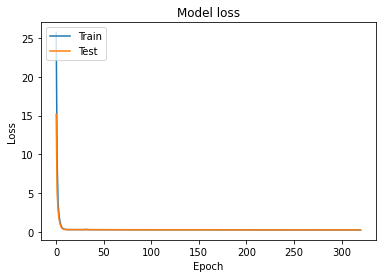

验证集上的最优结果是0.48477038741111755,对应训练轮次是318
create model. feature_dim =2028, label_dim =151
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_125 (Dense)           (None, 256)               519424    
                                                                 
 dense_126 (Dense)           (None, 256)               65792     
                                                                 
 dense_127 (Dense)           (None, 256)               65792     
                                                                 
 dense_128 (Dense)           (None, 256)               65792     
                                                                 
 dense_129 (Dense)           (None, 256)               65792     
                                                                 
 dense_130 (Dense)           (None, 151)               38807     
                              

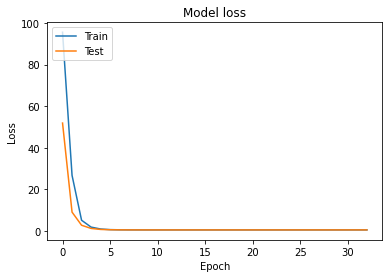

验证集上的最优结果是0.425189346075058,对应训练轮次是8
create model. feature_dim =2028, label_dim =151
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 256)               519424    
                                                                 
 dense_132 (Dense)           (None, 256)               65792     
                                                                 
 dense_133 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 3.1054 - JI: 0.3237 - val_loss: 1.5363 - val_JI: 0.3702
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 1.2536 - JI: 0.4065 - va

50/50 [==============================] - 0s 6ms/step - loss: 0.1964 - JI: 0.5180 - val_loss: 0.2025 - val_JI: 0.5071
Epoch 58/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1957 - JI: 0.5202 - val_loss: 0.2035 - val_JI: 0.5015
Epoch 59/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1955 - JI: 0.5208 - val_loss: 0.2011 - val_JI: 0.5062
Epoch 60/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1952 - JI: 0.5215 - val_loss: 0.2004 - val_JI: 0.5064
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1945 - JI: 0.5221 - val_loss: 0.2031 - val_JI: 0.5068
Epoch 62/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1947 - JI: 0.5221 - val_loss: 0.2011 - val_JI: 0.5040
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1937 - JI: 0.5239 - val_loss: 0.2000 - val_JI: 0.5106
Epoch 64/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1933 - JI: 0.5250 - val_los

Epoch 120/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1810 - JI: 0.5496 - val_loss: 0.1948 - val_JI: 0.5163
Epoch 121/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1817 - JI: 0.5486 - val_loss: 0.1943 - val_JI: 0.5159
Epoch 122/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1813 - JI: 0.5490 - val_loss: 0.1941 - val_JI: 0.5153
Epoch 123/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1812 - JI: 0.5486 - val_loss: 0.1935 - val_JI: 0.5220
Epoch 124/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1806 - JI: 0.5502 - val_loss: 0.1937 - val_JI: 0.5251
Epoch 125/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1805 - JI: 0.5495 - val_loss: 0.1936 - val_JI: 0.5220
Epoch 126/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1804 - JI: 0.5499 - val_loss: 0.1957 - val_JI: 0.5198
Epoch 127/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1805 -

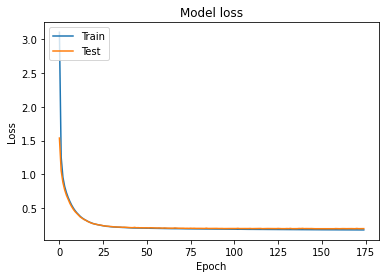

验证集上的最优结果是0.5273695588111877,对应训练轮次是160
create model. feature_dim =2028, label_dim =151
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_134 (Dense)           (None, 256)               519424    
                                                                 
 dense_135 (Dense)           (None, 256)               65792     
                                                                 
 dense_136 (Dense)           (None, 256)               65792     
                                                                 
 dense_137 (Dense)           (None, 256)               65792     
                                                                 
 dense_138 (Dense)           (None, 256)               65792     
                                                                 
 dense_139 (Dense)           (None, 151)               38807     
                               

50/50 [==============================] - 0s 8ms/step - loss: 0.2329 - JI: 0.4298 - val_loss: 0.2333 - val_JI: 0.4257
Epoch 55/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2328 - JI: 0.4298 - val_loss: 0.2332 - val_JI: 0.4253
Epoch 56/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2328 - JI: 0.4299 - val_loss: 0.2332 - val_JI: 0.4253
Epoch 57/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2328 - JI: 0.4297 - val_loss: 0.2331 - val_JI: 0.4243
Epoch 58/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2327 - JI: 0.4296 - val_loss: 0.2331 - val_JI: 0.4242
Epoch 59/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2327 - JI: 0.4294 - val_loss: 0.2330 - val_JI: 0.4253
Epoch 60/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2327 - JI: 0.4295 - val_loss: 0.2330 - val_JI: 0.4253
Epoch 61/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2326 - JI: 0.4293 - val_los

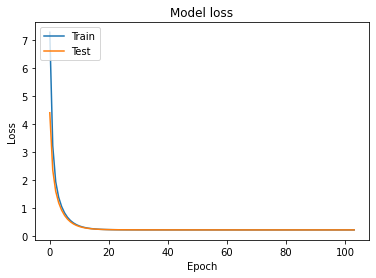

验证集上的最优结果是0.4265541732311249,对应训练轮次是28
create model. feature_dim =2028, label_dim =151
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 256)               519424    
                                                                 
 dense_141 (Dense)           (None, 256)               65792     
                                                                 
 dense_142 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 3.8840 - JI: 0.3294 - val_loss: 2.2092 - val_JI: 0.3876
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 1.7233 - JI: 0.4109 - 

50/50 [==============================] - 0s 7ms/step - loss: 0.2112 - JI: 0.5030 - val_loss: 0.2139 - val_JI: 0.4937
Epoch 58/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2097 - JI: 0.5033 - val_loss: 0.2148 - val_JI: 0.4942
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2092 - JI: 0.5046 - val_loss: 0.2141 - val_JI: 0.4942
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2089 - JI: 0.5065 - val_loss: 0.2131 - val_JI: 0.4940
Epoch 61/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2085 - JI: 0.5063 - val_loss: 0.2131 - val_JI: 0.4890
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2079 - JI: 0.5077 - val_loss: 0.2118 - val_JI: 0.4949
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2075 - JI: 0.5079 - val_loss: 0.2135 - val_JI: 0.4915
Epoch 64/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2079 - JI: 0.5072 - val_los

Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1955 - JI: 0.5353 - val_loss: 0.2062 - val_JI: 0.5157
Epoch 121/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1958 - JI: 0.5351 - val_loss: 0.2052 - val_JI: 0.5094
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1956 - JI: 0.5352 - val_loss: 0.2057 - val_JI: 0.5159
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1953 - JI: 0.5361 - val_loss: 0.2053 - val_JI: 0.5133
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1954 - JI: 0.5355 - val_loss: 0.2052 - val_JI: 0.5132
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1951 - JI: 0.5365 - val_loss: 0.2053 - val_JI: 0.5132
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1949 - JI: 0.5364 - val_loss: 0.2055 - val_JI: 0.5121
Epoch 127/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1953 -

50/50 [==============================] - 0s 7ms/step - loss: 0.1893 - JI: 0.5473 - val_loss: 0.2040 - val_JI: 0.5165
Epoch 183/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1897 - JI: 0.5472 - val_loss: 0.2053 - val_JI: 0.5106
Epoch 184/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1902 - JI: 0.5457 - val_loss: 0.2032 - val_JI: 0.5181
Epoch 185/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1890 - JI: 0.5486 - val_loss: 0.2042 - val_JI: 0.5137
Epoch 186/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1896 - JI: 0.5469 - val_loss: 0.2032 - val_JI: 0.5187
Epoch 187/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1889 - JI: 0.5480 - val_loss: 0.2038 - val_JI: 0.5139
Epoch 188/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1891 - JI: 0.5470 - val_loss: 0.2050 - val_JI: 0.5190
Epoch 189/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1889 - JI: 0.5486 - 

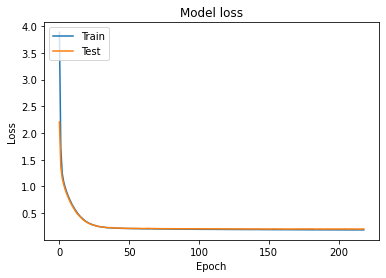

验证集上的最优结果是0.5214353799819946,对应训练轮次是215
create model. feature_dim =2028, label_dim =151
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_143 (Dense)           (None, 256)               519424    
                                                                 
 dense_144 (Dense)           (None, 256)               65792     
                                                                 
 dense_145 (Dense)           (None, 256)               65792     
                                                                 
 dense_146 (Dense)           (None, 256)               65792     
                                                                 
 dense_147 (Dense)           (None, 256)               65792     
                                                                 
 dense_148 (Dense)           (None, 151)               38807     
                               

50/50 [==============================] - 0s 8ms/step - loss: 0.2611 - JI: 0.4327 - val_loss: 0.2618 - val_JI: 0.4283
Epoch 55/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2610 - JI: 0.4332 - val_loss: 0.2618 - val_JI: 0.4286
Epoch 56/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2609 - JI: 0.4343 - val_loss: 0.2617 - val_JI: 0.4289
Epoch 57/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2608 - JI: 0.4342 - val_loss: 0.2616 - val_JI: 0.4289
Epoch 58/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2607 - JI: 0.4348 - val_loss: 0.2616 - val_JI: 0.4291
Epoch 59/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2606 - JI: 0.4352 - val_loss: 0.2616 - val_JI: 0.4301
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2606 - JI: 0.4352 - val_loss: 0.2616 - val_JI: 0.4299
Epoch 61/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2604 - JI: 0.4357 - val_los

Epoch 117/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2569 - JI: 0.4484 - val_loss: 0.2580 - val_JI: 0.4410
Epoch 118/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2568 - JI: 0.4484 - val_loss: 0.2579 - val_JI: 0.4421
Epoch 119/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2568 - JI: 0.4483 - val_loss: 0.2577 - val_JI: 0.4420
Epoch 120/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2567 - JI: 0.4483 - val_loss: 0.2580 - val_JI: 0.4411
Epoch 121/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2567 - JI: 0.4484 - val_loss: 0.2576 - val_JI: 0.4416
Epoch 122/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2567 - JI: 0.4491 - val_loss: 0.2577 - val_JI: 0.4415
Epoch 123/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2564 - JI: 0.4489 - val_loss: 0.2573 - val_JI: 0.4420
Epoch 124/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2563 -

50/50 [==============================] - 0s 9ms/step - loss: 0.2536 - JI: 0.4548 - val_loss: 0.2549 - val_JI: 0.4479
Epoch 180/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2535 - JI: 0.4548 - val_loss: 0.2548 - val_JI: 0.4478
Epoch 181/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2535 - JI: 0.4543 - val_loss: 0.2548 - val_JI: 0.4483
Epoch 182/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2535 - JI: 0.4544 - val_loss: 0.2550 - val_JI: 0.4475
Epoch 183/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2534 - JI: 0.4549 - val_loss: 0.2547 - val_JI: 0.4483
Epoch 184/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2534 - JI: 0.4549 - val_loss: 0.2548 - val_JI: 0.4482
Epoch 185/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2534 - JI: 0.4548 - val_loss: 0.2547 - val_JI: 0.4491
Epoch 186/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2534 - JI: 0.4547 - 

50/50 [==============================] - 0s 8ms/step - loss: 0.2525 - JI: 0.4566 - val_loss: 0.2543 - val_JI: 0.4495
Epoch 242/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2525 - JI: 0.4562 - val_loss: 0.2543 - val_JI: 0.4483
Epoch 243/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2526 - JI: 0.4561 - val_loss: 0.2543 - val_JI: 0.4492
Epoch 244/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2525 - JI: 0.4567 - val_loss: 0.2543 - val_JI: 0.4489
Epoch 245/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2525 - JI: 0.4562 - val_loss: 0.2542 - val_JI: 0.4482
Epoch 246/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2524 - JI: 0.4564 - val_loss: 0.2542 - val_JI: 0.4487
Epoch 247/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2525 - JI: 0.4562 - val_loss: 0.2543 - val_JI: 0.4488
Epoch 248/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2525 - JI: 0.4564 - 

50/50 [==============================] - 0s 8ms/step - loss: 0.2520 - JI: 0.4572 - val_loss: 0.2541 - val_JI: 0.4496
Epoch 304/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2522 - JI: 0.4568 - val_loss: 0.2541 - val_JI: 0.4494
Epoch 305/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2520 - JI: 0.4569 - val_loss: 0.2540 - val_JI: 0.4494
Epoch 306/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2520 - JI: 0.4571 - val_loss: 0.2540 - val_JI: 0.4493
Epoch 307/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2521 - JI: 0.4569 - val_loss: 0.2541 - val_JI: 0.4492
Epoch 308/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2521 - JI: 0.4570 - val_loss: 0.2540 - val_JI: 0.4487
Epoch 309/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2520 - JI: 0.4572 - val_loss: 0.2544 - val_JI: 0.4483
Epoch 310/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2521 - JI: 0.4570 - 

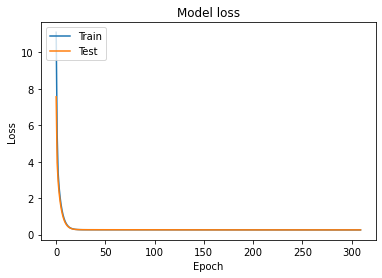

验证集上的最优结果是0.4497523307800293,对应训练轮次是260
create model. feature_dim =2028, label_dim =151
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_149 (Dense)           (None, 256)               519424    
                                                                 
 dense_150 (Dense)           (None, 256)               65792     
                                                                 
 dense_151 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.2310 - JI: 0.3265 - val_loss: 0.4649 - val_JI: 0.3796
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.4101 - JI: 0.4014 -

50/50 [==============================] - 0s 6ms/step - loss: 0.1901 - JI: 0.5497 - val_loss: 0.2082 - val_JI: 0.5007
Epoch 58/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1898 - JI: 0.5497 - val_loss: 0.2035 - val_JI: 0.5169
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1878 - JI: 0.5524 - val_loss: 0.2030 - val_JI: 0.5166
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1873 - JI: 0.5538 - val_loss: 0.2017 - val_JI: 0.5181
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1870 - JI: 0.5529 - val_loss: 0.2027 - val_JI: 0.5216
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1863 - JI: 0.5538 - val_loss: 0.2007 - val_JI: 0.5188
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1859 - JI: 0.5544 - val_loss: 0.2004 - val_JI: 0.5218
Epoch 64/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1857 - JI: 0.5542 - val_los

Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1660 - JI: 0.5833 - val_loss: 0.1947 - val_JI: 0.5264
Epoch 121/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1666 - JI: 0.5819 - val_loss: 0.1944 - val_JI: 0.5173
Epoch 122/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1663 - JI: 0.5827 - val_loss: 0.1957 - val_JI: 0.5274


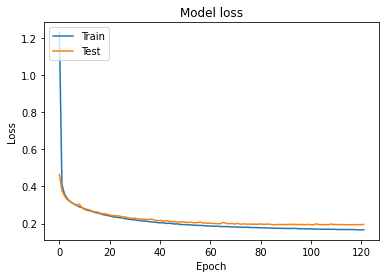

验证集上的最优结果是0.5282723307609558,对应训练轮次是88
create model. feature_dim =2028, label_dim =151
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_152 (Dense)           (None, 256)               519424    
                                                                 
 dense_153 (Dense)           (None, 256)               65792     
                                                                 
 dense_154 (Dense)           (None, 256)               65792     
                                                                 
 dense_155 (Dense)           (None, 256)               65792     
                                                                 
 dense_156 (Dense)           (None, 256)               65792     
                                                                 
 dense_157 (Dense)           (None, 151)               38807     
                                

50/50 [==============================] - 0s 9ms/step - loss: 0.2124 - JI: 0.5057 - val_loss: 0.2175 - val_JI: 0.4907
Epoch 55/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2127 - JI: 0.5033 - val_loss: 0.2174 - val_JI: 0.4919
Epoch 56/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2118 - JI: 0.5051 - val_loss: 0.2174 - val_JI: 0.4871
Epoch 57/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2105 - JI: 0.5063 - val_loss: 0.2169 - val_JI: 0.4887
Epoch 58/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2102 - JI: 0.5065 - val_loss: 0.2167 - val_JI: 0.4908
Epoch 59/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2097 - JI: 0.5069 - val_loss: 0.2143 - val_JI: 0.4930
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2088 - JI: 0.5082 - val_loss: 0.2140 - val_JI: 0.4934
Epoch 61/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2088 - JI: 0.5075 - val_los

Epoch 117/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1982 - JI: 0.5202 - val_loss: 0.2067 - val_JI: 0.4983
Epoch 118/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1984 - JI: 0.5201 - val_loss: 0.2067 - val_JI: 0.4987
Epoch 119/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1977 - JI: 0.5208 - val_loss: 0.2087 - val_JI: 0.4921
Epoch 120/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1976 - JI: 0.5215 - val_loss: 0.2066 - val_JI: 0.5003
Epoch 121/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1972 - JI: 0.5220 - val_loss: 0.2059 - val_JI: 0.5047
Epoch 122/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1975 - JI: 0.5215 - val_loss: 0.2063 - val_JI: 0.5029
Epoch 123/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1975 - JI: 0.5215 - val_loss: 0.2058 - val_JI: 0.5044
Epoch 124/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1971 -

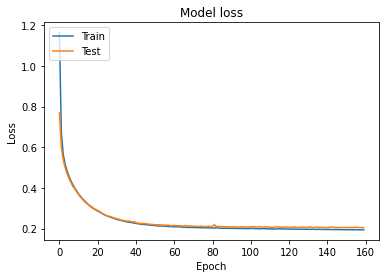

验证集上的最优结果是0.5068519711494446,对应训练轮次是145
create model. feature_dim =2028, label_dim =151
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_158 (Dense)           (None, 256)               519424    
                                                                 
 dense_159 (Dense)           (None, 256)               65792     
                                                                 
 dense_160 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.3962 - JI: 0.3311 - val_loss: 0.5553 - val_JI: 0.3804
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.4906 - JI: 0.4036 -

50/50 [==============================] - 0s 6ms/step - loss: 0.2079 - JI: 0.5477 - val_loss: 0.2211 - val_JI: 0.5221
Epoch 58/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2071 - JI: 0.5489 - val_loss: 0.2207 - val_JI: 0.5217
Epoch 59/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2053 - JI: 0.5504 - val_loss: 0.2203 - val_JI: 0.5100
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2048 - JI: 0.5500 - val_loss: 0.2173 - val_JI: 0.5205
Epoch 61/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2039 - JI: 0.5501 - val_loss: 0.2173 - val_JI: 0.5157
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2021 - JI: 0.5521 - val_loss: 0.2165 - val_JI: 0.5209
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2007 - JI: 0.5540 - val_loss: 0.2161 - val_JI: 0.5190
Epoch 64/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2003 - JI: 0.5524 - val_los

Epoch 120/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1742 - JI: 0.5773 - val_loss: 0.2007 - val_JI: 0.5199
Epoch 121/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1740 - JI: 0.5769 - val_loss: 0.1998 - val_JI: 0.5245
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1737 - JI: 0.5771 - val_loss: 0.2000 - val_JI: 0.5274
Epoch 123/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1733 - JI: 0.5780 - val_loss: 0.2001 - val_JI: 0.5210
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1734 - JI: 0.5773 - val_loss: 0.2009 - val_JI: 0.5251
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1732 - JI: 0.5782 - val_loss: 0.1998 - val_JI: 0.5193
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1737 - JI: 0.5771 - val_loss: 0.1997 - val_JI: 0.5226
Epoch 127/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1727 -

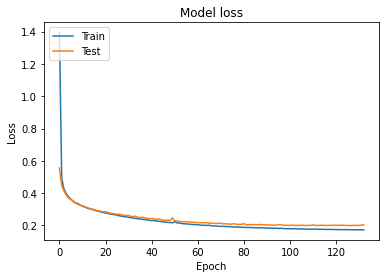

验证集上的最优结果是0.5303558707237244,对应训练轮次是82
create model. feature_dim =2028, label_dim =151
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_161 (Dense)           (None, 256)               519424    
                                                                 
 dense_162 (Dense)           (None, 256)               65792     
                                                                 
 dense_163 (Dense)           (None, 256)               65792     
                                                                 
 dense_164 (Dense)           (None, 256)               65792     
                                                                 
 dense_165 (Dense)           (None, 256)               65792     
                                                                 
 dense_166 (Dense)           (None, 151)               38807     
                                

50/50 [==============================] - 0s 8ms/step - loss: 0.2311 - JI: 0.5029 - val_loss: 0.2344 - val_JI: 0.4907
Epoch 55/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2302 - JI: 0.5019 - val_loss: 0.2335 - val_JI: 0.4893
Epoch 56/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2280 - JI: 0.5038 - val_loss: 0.2347 - val_JI: 0.4904
Epoch 57/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2274 - JI: 0.5032 - val_loss: 0.2306 - val_JI: 0.4908
Epoch 58/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2254 - JI: 0.5043 - val_loss: 0.2315 - val_JI: 0.4914
Epoch 59/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2245 - JI: 0.5045 - val_loss: 0.2293 - val_JI: 0.4906
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2235 - JI: 0.5040 - val_loss: 0.2296 - val_JI: 0.4846
Epoch 61/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2223 - JI: 0.5057 - val_los

Epoch 117/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2019 - JI: 0.5187 - val_loss: 0.2106 - val_JI: 0.4985
Epoch 118/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2013 - JI: 0.5198 - val_loss: 0.2103 - val_JI: 0.4990
Epoch 119/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2015 - JI: 0.5191 - val_loss: 0.2115 - val_JI: 0.4983
Epoch 120/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2011 - JI: 0.5204 - val_loss: 0.2121 - val_JI: 0.4900
Epoch 121/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2010 - JI: 0.5201 - val_loss: 0.2105 - val_JI: 0.4966
Epoch 122/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2013 - JI: 0.5195 - val_loss: 0.2112 - val_JI: 0.4990
Epoch 123/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2006 - JI: 0.5210 - val_loss: 0.2130 - val_JI: 0.4874
Epoch 124/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2007 -

50/50 [==============================] - 0s 9ms/step - loss: 0.1945 - JI: 0.5318 - val_loss: 0.2074 - val_JI: 0.5036
Epoch 180/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1953 - JI: 0.5301 - val_loss: 0.2110 - val_JI: 0.4929
Epoch 181/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1952 - JI: 0.5301 - val_loss: 0.2081 - val_JI: 0.5052
Epoch 182/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1945 - JI: 0.5316 - val_loss: 0.2086 - val_JI: 0.4970
Epoch 183/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1953 - JI: 0.5301 - val_loss: 0.2079 - val_JI: 0.5023


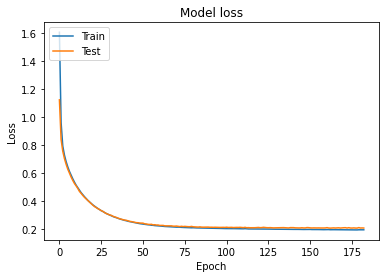

验证集上的最优结果是0.505278468132019,对应训练轮次是170
create model. feature_dim =2028, label_dim =151
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_167 (Dense)           (None, 256)               519424    
                                                                 
 dense_168 (Dense)           (None, 256)               65792     
                                                                 
 dense_169 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.1193 - JI: 0.3353 - val_loss: 0.3081 - val_JI: 0.3937
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2819 - JI: 0.4102 - 

50/50 [==============================] - 0s 6ms/step - loss: 0.1792 - JI: 0.5588 - val_loss: 0.1987 - val_JI: 0.5207
Epoch 58/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1773 - JI: 0.5625 - val_loss: 0.1984 - val_JI: 0.5190
Epoch 59/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1768 - JI: 0.5639 - val_loss: 0.1980 - val_JI: 0.5189
Epoch 60/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1772 - JI: 0.5628 - val_loss: 0.1989 - val_JI: 0.5145
Epoch 61/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1778 - JI: 0.5616 - val_loss: 0.1996 - val_JI: 0.5163
Epoch 62/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1760 - JI: 0.5649 - val_loss: 0.1992 - val_JI: 0.5154
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1752 - JI: 0.5668 - val_loss: 0.1994 - val_JI: 0.5140
Epoch 64/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1759 - JI: 0.5652 - val_los

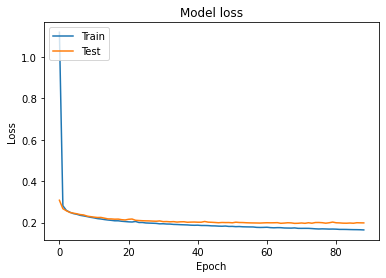

验证集上的最优结果是0.5230194926261902,对应训练轮次是74
create model. feature_dim =2028, label_dim =151
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_170 (Dense)           (None, 256)               519424    
                                                                 
 dense_171 (Dense)           (None, 256)               65792     
                                                                 
 dense_172 (Dense)           (None, 256)               65792     
                                                                 
 dense_173 (Dense)           (None, 256)               65792     
                                                                 
 dense_174 (Dense)           (None, 256)               65792     
                                                                 
 dense_175 (Dense)           (None, 151)               38807     
                                

50/50 [==============================] - 0s 8ms/step - loss: 0.1935 - JI: 0.5446 - val_loss: 0.2074 - val_JI: 0.5194
Epoch 55/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1926 - JI: 0.5459 - val_loss: 0.2075 - val_JI: 0.5115
Epoch 56/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1924 - JI: 0.5454 - val_loss: 0.2076 - val_JI: 0.5105
Epoch 57/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1912 - JI: 0.5489 - val_loss: 0.2057 - val_JI: 0.5174
Epoch 58/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1906 - JI: 0.5488 - val_loss: 0.2053 - val_JI: 0.5165
Epoch 59/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1901 - JI: 0.5501 - val_loss: 0.2034 - val_JI: 0.5214
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1891 - JI: 0.5504 - val_loss: 0.2045 - val_JI: 0.5155
Epoch 61/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1900 - JI: 0.5488 - val_los

Epoch 117/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1720 - JI: 0.5768 - val_loss: 0.2011 - val_JI: 0.5211
Epoch 118/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1714 - JI: 0.5778 - val_loss: 0.2042 - val_JI: 0.5082
Epoch 119/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1717 - JI: 0.5770 - val_loss: 0.2005 - val_JI: 0.5248
Epoch 120/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1701 - JI: 0.5814 - val_loss: 0.2023 - val_JI: 0.5228
Epoch 121/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1703 - JI: 0.5809 - val_loss: 0.1990 - val_JI: 0.5212
Epoch 122/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1709 - JI: 0.5794 - val_loss: 0.2018 - val_JI: 0.5126
Epoch 123/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1700 - JI: 0.5817 - val_loss: 0.2021 - val_JI: 0.5190
Epoch 124/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1704 -

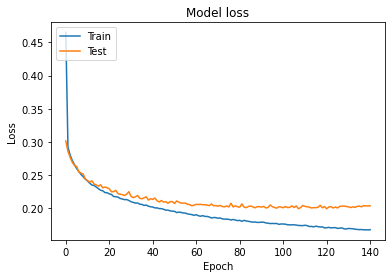

验证集上的最优结果是0.5253883600234985,对应训练轮次是136
create model. feature_dim =2028, label_dim =151
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_176 (Dense)           (None, 256)               519424    
                                                                 
 dense_177 (Dense)           (None, 256)               65792     
                                                                 
 dense_178 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.2155 - JI: 0.3306 - val_loss: 0.3204 - val_JI: 0.3816
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2913 - JI: 0.4045 -

50/50 [==============================] - 0s 7ms/step - loss: 0.1834 - JI: 0.5613 - val_loss: 0.2047 - val_JI: 0.5197
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1833 - JI: 0.5609 - val_loss: 0.2035 - val_JI: 0.5206
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1821 - JI: 0.5646 - val_loss: 0.2056 - val_JI: 0.5122
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1830 - JI: 0.5618 - val_loss: 0.2073 - val_JI: 0.5114
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1842 - JI: 0.5593 - val_loss: 0.2086 - val_JI: 0.5032
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1831 - JI: 0.5610 - val_loss: 0.2053 - val_JI: 0.5137
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1821 - JI: 0.5628 - val_loss: 0.2028 - val_JI: 0.5196
Epoch 64/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1797 - JI: 0.5673 - val_los

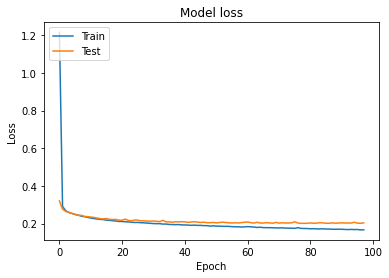

验证集上的最优结果是0.5235233902931213,对应训练轮次是80
create model. feature_dim =2028, label_dim =151
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_179 (Dense)           (None, 256)               519424    
                                                                 
 dense_180 (Dense)           (None, 256)               65792     
                                                                 
 dense_181 (Dense)           (None, 256)               65792     
                                                                 
 dense_182 (Dense)           (None, 256)               65792     
                                                                 
 dense_183 (Dense)           (None, 256)               65792     
                                                                 
 dense_184 (Dense)           (None, 151)               38807     
                                

50/50 [==============================] - 0s 8ms/step - loss: 0.2115 - JI: 0.5443 - val_loss: 0.2299 - val_JI: 0.4994
Epoch 55/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2131 - JI: 0.5411 - val_loss: 0.2238 - val_JI: 0.5178
Epoch 56/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2093 - JI: 0.5473 - val_loss: 0.2286 - val_JI: 0.5142
Epoch 57/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2095 - JI: 0.5456 - val_loss: 0.2250 - val_JI: 0.5187
Epoch 58/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2091 - JI: 0.5461 - val_loss: 0.2267 - val_JI: 0.5043
Epoch 59/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2089 - JI: 0.5452 - val_loss: 0.2234 - val_JI: 0.5103
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2070 - JI: 0.5481 - val_loss: 0.2212 - val_JI: 0.5210
Epoch 61/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2060 - JI: 0.5495 - val_los

Epoch 117/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1796 - JI: 0.5742 - val_loss: 0.2050 - val_JI: 0.5255
Epoch 118/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1798 - JI: 0.5736 - val_loss: 0.2055 - val_JI: 0.5217
Epoch 119/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1801 - JI: 0.5725 - val_loss: 0.2070 - val_JI: 0.5201
Epoch 120/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1783 - JI: 0.5768 - val_loss: 0.2065 - val_JI: 0.5179
Epoch 121/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1790 - JI: 0.5744 - val_loss: 0.2067 - val_JI: 0.5157
Epoch 122/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1776 - JI: 0.5778 - val_loss: 0.2078 - val_JI: 0.5233
Epoch 123/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1775 - JI: 0.5771 - val_loss: 0.2066 - val_JI: 0.5166
Epoch 124/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1771 -

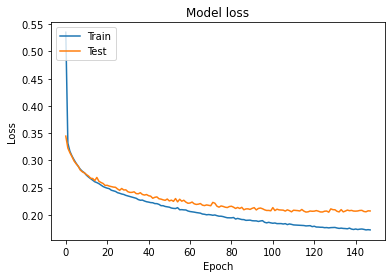

验证集上的最优结果是0.5254664421081543,对应训练轮次是117
create model. feature_dim =2028, label_dim =151
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_185 (Dense)           (None, 256)               519424    
                                                                 
 dense_186 (Dense)           (None, 256)               65792     
                                                                 
 dense_187 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.1979 - JI: 0.3264 - val_loss: 0.3011 - val_JI: 0.3799
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2710 - JI: 0.4021 -

50/50 [==============================] - 0s 6ms/step - loss: 0.1742 - JI: 0.5597 - val_loss: 0.2001 - val_JI: 0.5127
Epoch 58/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1759 - JI: 0.5564 - val_loss: 0.1968 - val_JI: 0.5196
Epoch 59/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1736 - JI: 0.5608 - val_loss: 0.1961 - val_JI: 0.5131
Epoch 60/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1732 - JI: 0.5612 - val_loss: 0.1996 - val_JI: 0.5119
Epoch 61/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1739 - JI: 0.5606 - val_loss: 0.1976 - val_JI: 0.5174
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1721 - JI: 0.5635 - val_loss: 0.1949 - val_JI: 0.5194
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1718 - JI: 0.5649 - val_loss: 0.1969 - val_JI: 0.5206
Epoch 64/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1715 - JI: 0.5646 - val_los

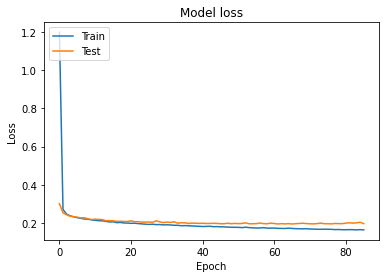

验证集上的最优结果是0.5233848690986633,对应训练轮次是75
create model. feature_dim =2028, label_dim =151
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_188 (Dense)           (None, 256)               519424    
                                                                 
 dense_189 (Dense)           (None, 256)               65792     
                                                                 
 dense_190 (Dense)           (None, 256)               65792     
                                                                 
 dense_191 (Dense)           (None, 256)               65792     
                                                                 
 dense_192 (Dense)           (None, 256)               65792     
                                                                 
 dense_193 (Dense)           (None, 151)               38807     
                                

50/50 [==============================] - 0s 8ms/step - loss: 0.1751 - JI: 0.5612 - val_loss: 0.2042 - val_JI: 0.5142
Epoch 55/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1744 - JI: 0.5627 - val_loss: 0.2024 - val_JI: 0.5083
Epoch 56/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1738 - JI: 0.5646 - val_loss: 0.2001 - val_JI: 0.5122
Epoch 57/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1724 - JI: 0.5675 - val_loss: 0.1997 - val_JI: 0.5133
Epoch 58/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1732 - JI: 0.5655 - val_loss: 0.2022 - val_JI: 0.5134


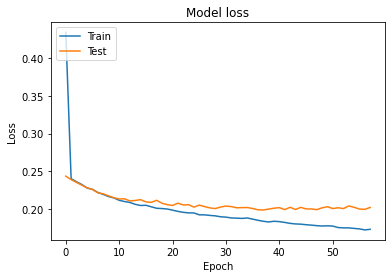

验证集上的最优结果是0.5156327486038208,对应训练轮次是47
create model. feature_dim =2028, label_dim =151
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_194 (Dense)           (None, 256)               519424    
                                                                 
 dense_195 (Dense)           (None, 256)               65792     
                                                                 
 dense_196 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.0648 - JI: 0.3234 - val_loss: 0.2787 - val_JI: 0.3879
Epoch 2/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2623 - JI: 0.4063 - 

50/50 [==============================] - 0s 6ms/step - loss: 0.1768 - JI: 0.5554 - val_loss: 0.1971 - val_JI: 0.5118
Epoch 58/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1763 - JI: 0.5566 - val_loss: 0.1992 - val_JI: 0.5063
Epoch 59/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1766 - JI: 0.5546 - val_loss: 0.1988 - val_JI: 0.5055
Epoch 60/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1772 - JI: 0.5543 - val_loss: 0.1964 - val_JI: 0.5164
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1761 - JI: 0.5562 - val_loss: 0.2027 - val_JI: 0.5098
Epoch 62/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1773 - JI: 0.5539 - val_loss: 0.1965 - val_JI: 0.5142
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1753 - JI: 0.5574 - val_loss: 0.1953 - val_JI: 0.5195
Epoch 64/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1751 - JI: 0.5581 - val_los

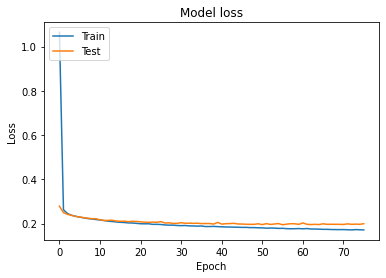

验证集上的最优结果是0.5218098163604736,对应训练轮次是67
create model. feature_dim =2028, label_dim =151
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_197 (Dense)           (None, 256)               519424    
                                                                 
 dense_198 (Dense)           (None, 256)               65792     
                                                                 
 dense_199 (Dense)           (None, 256)               65792     
                                                                 
 dense_200 (Dense)           (None, 256)               65792     
                                                                 
 dense_201 (Dense)           (None, 256)               65792     
                                                                 
 dense_202 (Dense)           (None, 151)               38807     
                                

50/50 [==============================] - 0s 9ms/step - loss: 0.1779 - JI: 0.5601 - val_loss: 0.2006 - val_JI: 0.5159
Epoch 55/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1772 - JI: 0.5623 - val_loss: 0.2012 - val_JI: 0.5184
Epoch 56/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1763 - JI: 0.5642 - val_loss: 0.2037 - val_JI: 0.5034
Epoch 57/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1767 - JI: 0.5625 - val_loss: 0.2018 - val_JI: 0.5165
Epoch 58/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1767 - JI: 0.5633 - val_loss: 0.2031 - val_JI: 0.5082
Epoch 59/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1742 - JI: 0.5685 - val_loss: 0.2061 - val_JI: 0.5138
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1748 - JI: 0.5666 - val_loss: 0.2033 - val_JI: 0.5169
Epoch 61/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1738 - JI: 0.5690 - val_los

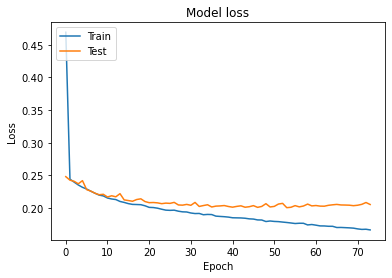

验证集上的最优结果是0.5184987187385559,对应训练轮次是64
create model. feature_dim =2028, label_dim =151
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_203 (Dense)           (None, 256)               519424    
                                                                 
 dense_204 (Dense)           (None, 256)               65792     
                                                                 
 dense_205 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.0173 - JI: 0.3366 - val_loss: 0.2856 - val_JI: 0.3896
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2635 - JI: 0.4096 - 

50/50 [==============================] - 0s 7ms/step - loss: 0.1723 - JI: 0.5607 - val_loss: 0.1939 - val_JI: 0.5183
Epoch 58/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1708 - JI: 0.5634 - val_loss: 0.1952 - val_JI: 0.5192
Epoch 59/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1701 - JI: 0.5657 - val_loss: 0.1952 - val_JI: 0.5163
Epoch 60/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1706 - JI: 0.5634 - val_loss: 0.1980 - val_JI: 0.5201
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1710 - JI: 0.5636 - val_loss: 0.1963 - val_JI: 0.5117
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1705 - JI: 0.5640 - val_loss: 0.1938 - val_JI: 0.5178
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1692 - JI: 0.5666 - val_loss: 0.1967 - val_JI: 0.5178
Epoch 64/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1688 - JI: 0.5675 - val_los

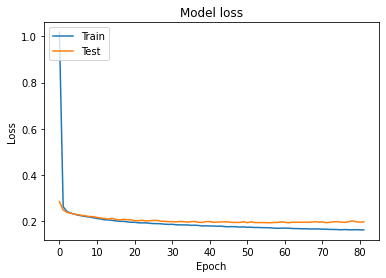

验证集上的最优结果是0.5202046036720276,对应训练轮次是81
create model. feature_dim =2028, label_dim =151
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_206 (Dense)           (None, 256)               519424    
                                                                 
 dense_207 (Dense)           (None, 256)               65792     
                                                                 
 dense_208 (Dense)           (None, 256)               65792     
                                                                 
 dense_209 (Dense)           (None, 256)               65792     
                                                                 
 dense_210 (Dense)           (None, 256)               65792     
                                                                 
 dense_211 (Dense)           (None, 151)               38807     
                                

50/50 [==============================] - 0s 8ms/step - loss: 0.1694 - JI: 0.5649 - val_loss: 0.1991 - val_JI: 0.5138
Epoch 55/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1693 - JI: 0.5651 - val_loss: 0.1996 - val_JI: 0.5128
Epoch 56/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1688 - JI: 0.5675 - val_loss: 0.1983 - val_JI: 0.5136
Epoch 57/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1661 - JI: 0.5718 - val_loss: 0.2001 - val_JI: 0.5121
Epoch 58/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1654 - JI: 0.5739 - val_loss: 0.2026 - val_JI: 0.4985
Epoch 59/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1657 - JI: 0.5728 - val_loss: 0.2000 - val_JI: 0.5155
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1652 - JI: 0.5739 - val_loss: 0.1977 - val_JI: 0.5144
Epoch 61/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1633 - JI: 0.5780 - val_los

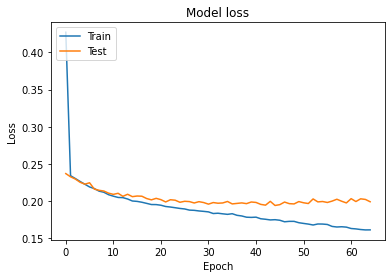

验证集上的最优结果是0.5171851515769958,对应训练轮次是45


[0.42576614022254944,
 0.425189346075058,
 0.5099629759788513,
 0.425189346075058,
 0.45900270342826843,
 0.425189346075058,
 0.5163905024528503,
 0.425189346075058,
 0.48477038741111755,
 0.425189346075058,
 0.5273695588111877,
 0.4265541732311249,
 0.5214353799819946,
 0.4497523307800293,
 0.5282723307609558,
 0.5068519711494446,
 0.5303558707237244,
 0.505278468132019,
 0.5230194926261902,
 0.5253883600234985,
 0.5235233902931213,
 0.5254664421081543,
 0.5233848690986633,
 0.5156327486038208,
 0.5218098163604736,
 0.5184987187385559,
 0.5202046036720276,
 0.5171851515769958]

In [32]:
results = []
# 调正则化参数及隐层层数
for re in kernel_regularizer_list:
    results.append(train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],use_kernel_regularizer = True,kernel_regularizer = re))
    results.append(train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],hidden_layer_num = 4,use_kernel_regularizer = True,kernel_regularizer = re))
results
    


create model. feature_dim =2028, label_dim =151
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_212 (Dense)           (None, 256)               519424    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_213 (Dense)           (None, 256)               65792     
                                                                 
 dense_214 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.6366 - JI: 0.3060 - val_loss: 0.5553 - val_JI: 0.3861
Ep

50/50 [==============================] - 0s 8ms/step - loss: 0.2085 - JI: 0.5185 - val_loss: 0.2117 - val_JI: 0.5065
Epoch 57/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2075 - JI: 0.5194 - val_loss: 0.2113 - val_JI: 0.5132
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2070 - JI: 0.5179 - val_loss: 0.2102 - val_JI: 0.5086
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2063 - JI: 0.5184 - val_loss: 0.2094 - val_JI: 0.5073
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2048 - JI: 0.5193 - val_loss: 0.2090 - val_JI: 0.5101
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2036 - JI: 0.5215 - val_loss: 0.2081 - val_JI: 0.5087
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2036 - JI: 0.5203 - val_loss: 0.2070 - val_JI: 0.5077
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2025 - JI: 0.5203 - val_los

Epoch 119/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1856 - JI: 0.5349 - val_loss: 0.1947 - val_JI: 0.5181
Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1856 - JI: 0.5347 - val_loss: 0.1952 - val_JI: 0.5204
Epoch 121/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1860 - JI: 0.5346 - val_loss: 0.1935 - val_JI: 0.5169
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1855 - JI: 0.5353 - val_loss: 0.1955 - val_JI: 0.5160
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1853 - JI: 0.5364 - val_loss: 0.1935 - val_JI: 0.5155
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1852 - JI: 0.5360 - val_loss: 0.1939 - val_JI: 0.5180
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1852 - JI: 0.5365 - val_loss: 0.1946 - val_JI: 0.5203
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1848 -

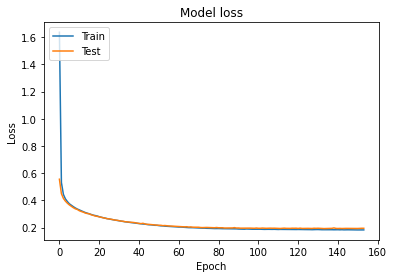

验证集上的最优结果是0.5207446217536926,对应训练轮次是112
create model. feature_dim =2028, label_dim =151
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_215 (Dense)           (None, 256)               519424    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_216 (Dense)           (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_217 (Dense)           (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                               

50/50 [==============================] - 1s 10ms/step - loss: 0.2263 - JI: 0.4649 - val_loss: 0.2253 - val_JI: 0.4638
Epoch 50/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2257 - JI: 0.4651 - val_loss: 0.2247 - val_JI: 0.4625
Epoch 51/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2250 - JI: 0.4659 - val_loss: 0.2238 - val_JI: 0.4636
Epoch 52/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2244 - JI: 0.4666 - val_loss: 0.2240 - val_JI: 0.4621
Epoch 53/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2239 - JI: 0.4671 - val_loss: 0.2242 - val_JI: 0.4647
Epoch 54/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2236 - JI: 0.4675 - val_loss: 0.2227 - val_JI: 0.4636
Epoch 55/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2226 - JI: 0.4681 - val_loss: 0.2221 - val_JI: 0.4671
Epoch 56/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2223 - JI: 0.4681 -

50/50 [==============================] - 1s 10ms/step - loss: 0.2145 - JI: 0.4808 - val_loss: 0.2165 - val_JI: 0.4782
Epoch 112/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2147 - JI: 0.4815 - val_loss: 0.2166 - val_JI: 0.4745
Epoch 113/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2148 - JI: 0.4815 - val_loss: 0.2171 - val_JI: 0.4727
Epoch 114/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2148 - JI: 0.4804 - val_loss: 0.2162 - val_JI: 0.4757
Epoch 115/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2143 - JI: 0.4818 - val_loss: 0.2164 - val_JI: 0.4736
Epoch 116/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2141 - JI: 0.4818 - val_loss: 0.2172 - val_JI: 0.4763
Epoch 117/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2144 - JI: 0.4816 - val_loss: 0.2165 - val_JI: 0.4747
Epoch 118/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2141 - JI: 0

50/50 [==============================] - 1s 10ms/step - loss: 0.2122 - JI: 0.4856 - val_loss: 0.2161 - val_JI: 0.4792
Epoch 174/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2116 - JI: 0.4873 - val_loss: 0.2151 - val_JI: 0.4796
Epoch 175/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2116 - JI: 0.4870 - val_loss: 0.2155 - val_JI: 0.4780
Epoch 176/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2115 - JI: 0.4869 - val_loss: 0.2150 - val_JI: 0.4802
Epoch 177/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2115 - JI: 0.4871 - val_loss: 0.2152 - val_JI: 0.4792
Epoch 178/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2115 - JI: 0.4879 - val_loss: 0.2158 - val_JI: 0.4768
Epoch 179/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2116 - JI: 0.4870 - val_loss: 0.2150 - val_JI: 0.4794
Epoch 180/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2115 - JI: 0

50/50 [==============================] - 1s 11ms/step - loss: 0.2104 - JI: 0.4903 - val_loss: 0.2151 - val_JI: 0.4824
Epoch 236/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2100 - JI: 0.4907 - val_loss: 0.2149 - val_JI: 0.4830
Epoch 237/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2098 - JI: 0.4912 - val_loss: 0.2142 - val_JI: 0.4818
Epoch 238/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2097 - JI: 0.4913 - val_loss: 0.2138 - val_JI: 0.4838
Epoch 239/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2096 - JI: 0.4925 - val_loss: 0.2152 - val_JI: 0.4787
Epoch 240/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2099 - JI: 0.4905 - val_loss: 0.2147 - val_JI: 0.4821
Epoch 241/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2098 - JI: 0.4916 - val_loss: 0.2138 - val_JI: 0.4833
Epoch 242/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2100 - JI: 0

50/50 [==============================] - 1s 10ms/step - loss: 0.2092 - JI: 0.4938 - val_loss: 0.2136 - val_JI: 0.4819
Epoch 298/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2085 - JI: 0.4948 - val_loss: 0.2128 - val_JI: 0.4855
Epoch 299/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2081 - JI: 0.4950 - val_loss: 0.2131 - val_JI: 0.4865
Epoch 300/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2082 - JI: 0.4953 - val_loss: 0.2131 - val_JI: 0.4867
Epoch 301/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2087 - JI: 0.4943 - val_loss: 0.2133 - val_JI: 0.4843
Epoch 302/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2090 - JI: 0.4943 - val_loss: 0.2148 - val_JI: 0.4844
Epoch 303/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2083 - JI: 0.4956 - val_loss: 0.2132 - val_JI: 0.4844
Epoch 304/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2081 - JI: 0

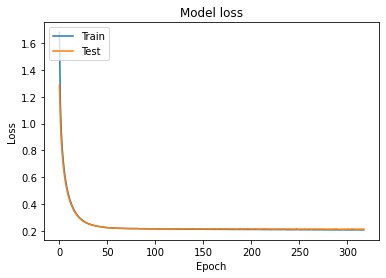

验证集上的最优结果是0.48857381939888,对应训练轮次是309
create model. feature_dim =2028, label_dim =151
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_221 (Dense)           (None, 256)               519424    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_222 (Dense)           (None, 256)               65792     
                                                                 
 dense_223 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.7561 - JI: 0.3087 

50/50 [==============================] - 0s 7ms/step - loss: 0.2121 - JI: 0.5012 - val_loss: 0.2124 - val_JI: 0.4987
Epoch 57/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2108 - JI: 0.5026 - val_loss: 0.2124 - val_JI: 0.5018
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2100 - JI: 0.5024 - val_loss: 0.2117 - val_JI: 0.4983
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2092 - JI: 0.5041 - val_loss: 0.2104 - val_JI: 0.4997
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2079 - JI: 0.5047 - val_loss: 0.2088 - val_JI: 0.4985
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2081 - JI: 0.5033 - val_loss: 0.2079 - val_JI: 0.5038
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2069 - JI: 0.5052 - val_loss: 0.2084 - val_JI: 0.4991
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2068 - JI: 0.5040 - val_los

Epoch 119/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1941 - JI: 0.5179 - val_loss: 0.1979 - val_JI: 0.5072
Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1940 - JI: 0.5177 - val_loss: 0.1981 - val_JI: 0.5092
Epoch 121/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1937 - JI: 0.5184 - val_loss: 0.1972 - val_JI: 0.5080
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1935 - JI: 0.5183 - val_loss: 0.2014 - val_JI: 0.4967
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1936 - JI: 0.5193 - val_loss: 0.1970 - val_JI: 0.5085
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1935 - JI: 0.5182 - val_loss: 0.1983 - val_JI: 0.5039
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1936 - JI: 0.5188 - val_loss: 0.1994 - val_JI: 0.5022
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1938 -

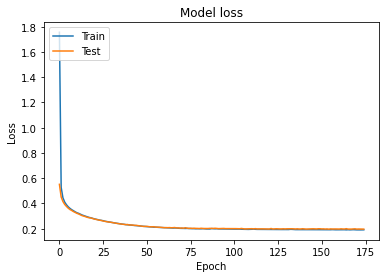

验证集上的最优结果是0.5105302929878235,对应训练轮次是175
create model. feature_dim =2028, label_dim =151
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_224 (Dense)           (None, 256)               519424    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_225 (Dense)           (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_226 (Dense)           (None, 256)               65792     
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                               

50/50 [==============================] - 1s 11ms/step - loss: 0.2361 - JI: 0.4454 - val_loss: 0.2358 - val_JI: 0.4411
Epoch 50/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2354 - JI: 0.4457 - val_loss: 0.2349 - val_JI: 0.4423
Epoch 51/500
50/50 [==============================] - 0s 10ms/step - loss: 0.2347 - JI: 0.4458 - val_loss: 0.2348 - val_JI: 0.4430
Epoch 52/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2342 - JI: 0.4465 - val_loss: 0.2335 - val_JI: 0.4427
Epoch 53/500
50/50 [==============================] - 0s 10ms/step - loss: 0.2333 - JI: 0.4468 - val_loss: 0.2327 - val_JI: 0.4439
Epoch 54/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2325 - JI: 0.4478 - val_loss: 0.2325 - val_JI: 0.4428
Epoch 55/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2322 - JI: 0.4478 - val_loss: 0.2318 - val_JI: 0.4426
Epoch 56/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2318 - JI: 0.4482 -

50/50 [==============================] - 1s 10ms/step - loss: 0.2261 - JI: 0.4537 - val_loss: 0.2267 - val_JI: 0.4492
Epoch 112/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2259 - JI: 0.4542 - val_loss: 0.2269 - val_JI: 0.4470
Epoch 113/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2260 - JI: 0.4543 - val_loss: 0.2268 - val_JI: 0.4490
Epoch 114/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2258 - JI: 0.4547 - val_loss: 0.2268 - val_JI: 0.4493
Epoch 115/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2258 - JI: 0.4543 - val_loss: 0.2269 - val_JI: 0.4482


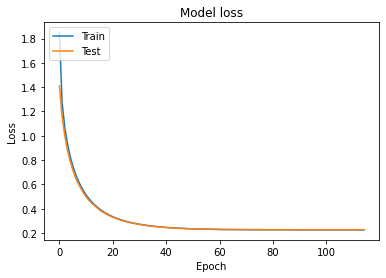

验证集上的最优结果是0.4501694142818451,对应训练轮次是105
create model. feature_dim =2028, label_dim =151
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_230 (Dense)           (None, 256)               519424    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_231 (Dense)           (None, 256)               65792     
                                                                 
 dense_232 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.8631 - JI: 0.298

50/50 [==============================] - 0s 7ms/step - loss: 0.2164 - JI: 0.4906 - val_loss: 0.2168 - val_JI: 0.4952
Epoch 57/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2158 - JI: 0.4923 - val_loss: 0.2132 - val_JI: 0.4961
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2148 - JI: 0.4914 - val_loss: 0.2172 - val_JI: 0.4901
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2146 - JI: 0.4908 - val_loss: 0.2163 - val_JI: 0.4896
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2131 - JI: 0.4924 - val_loss: 0.2122 - val_JI: 0.4935
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2125 - JI: 0.4931 - val_loss: 0.2131 - val_JI: 0.4929
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2119 - JI: 0.4939 - val_loss: 0.2114 - val_JI: 0.4963
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2106 - JI: 0.4949 - val_los

Epoch 119/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1988 - JI: 0.5069 - val_loss: 0.2018 - val_JI: 0.4984
Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1991 - JI: 0.5072 - val_loss: 0.2037 - val_JI: 0.4962
Epoch 121/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1993 - JI: 0.5066 - val_loss: 0.2019 - val_JI: 0.5024
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1999 - JI: 0.5053 - val_loss: 0.2026 - val_JI: 0.4972
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1990 - JI: 0.5072 - val_loss: 0.2024 - val_JI: 0.4999
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1989 - JI: 0.5077 - val_loss: 0.2037 - val_JI: 0.4938
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1986 - JI: 0.5072 - val_loss: 0.2026 - val_JI: 0.5018
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1988 -

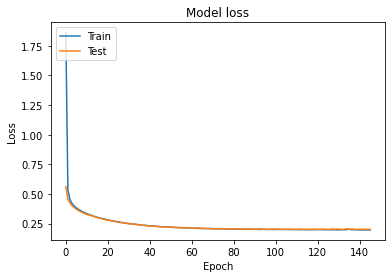

验证集上的最优结果是0.5031652450561523,对应训练轮次是140
create model. feature_dim =2028, label_dim =151
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_233 (Dense)           (None, 256)               519424    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_234 (Dense)           (None, 256)               65792     
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_235 (Dense)           (None, 256)               65792     
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                               

50/50 [==============================] - 1s 10ms/step - loss: 0.2444 - JI: 0.4425 - val_loss: 0.2432 - val_JI: 0.4416
Epoch 50/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2429 - JI: 0.4437 - val_loss: 0.2419 - val_JI: 0.4407
Epoch 51/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2416 - JI: 0.4438 - val_loss: 0.2405 - val_JI: 0.4414
Epoch 52/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2403 - JI: 0.4443 - val_loss: 0.2393 - val_JI: 0.4423
Epoch 53/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2392 - JI: 0.4455 - val_loss: 0.2383 - val_JI: 0.4414
Epoch 54/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2383 - JI: 0.4458 - val_loss: 0.2375 - val_JI: 0.4417
Epoch 55/500
50/50 [==============================] - 1s 12ms/step - loss: 0.2375 - JI: 0.4450 - val_loss: 0.2366 - val_JI: 0.4427
Epoch 56/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2365 - JI: 0.4459 -

50/50 [==============================] - 1s 10ms/step - loss: 0.2274 - JI: 0.4507 - val_loss: 0.2276 - val_JI: 0.4493
Epoch 112/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2275 - JI: 0.4509 - val_loss: 0.2274 - val_JI: 0.4475
Epoch 113/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2274 - JI: 0.4513 - val_loss: 0.2275 - val_JI: 0.4464
Epoch 114/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2274 - JI: 0.4506 - val_loss: 0.2276 - val_JI: 0.4490
Epoch 115/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2275 - JI: 0.4515 - val_loss: 0.2276 - val_JI: 0.4473
Epoch 116/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2275 - JI: 0.4506 - val_loss: 0.2279 - val_JI: 0.4480
Epoch 117/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2273 - JI: 0.4516 - val_loss: 0.2281 - val_JI: 0.4482
Epoch 118/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2277 - JI: 0

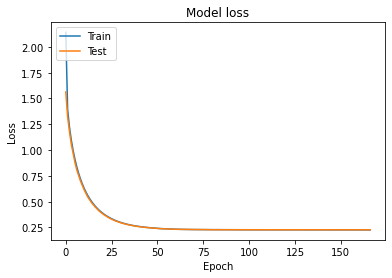

验证集上的最优结果是0.4501384198665619,对应训练轮次是149
create model. feature_dim =2028, label_dim =151
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_239 (Dense)           (None, 256)               519424    
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_240 (Dense)           (None, 256)               65792     
                                                                 
 dense_241 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.8284 - JI: 0.296

50/50 [==============================] - 0s 7ms/step - loss: 0.2164 - JI: 0.4830 - val_loss: 0.2164 - val_JI: 0.4786
Epoch 57/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2151 - JI: 0.4852 - val_loss: 0.2184 - val_JI: 0.4676
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2147 - JI: 0.4854 - val_loss: 0.2192 - val_JI: 0.4684
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2147 - JI: 0.4846 - val_loss: 0.2167 - val_JI: 0.4703
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2135 - JI: 0.4865 - val_loss: 0.2159 - val_JI: 0.4749
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2131 - JI: 0.4858 - val_loss: 0.2154 - val_JI: 0.4805
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2130 - JI: 0.4863 - val_loss: 0.2160 - val_JI: 0.4747
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2116 - JI: 0.4876 - val_los

Epoch 119/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2042 - JI: 0.4965 - val_loss: 0.2180 - val_JI: 0.4578
Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2049 - JI: 0.4951 - val_loss: 0.2200 - val_JI: 0.4532
Epoch 121/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2038 - JI: 0.4968 - val_loss: 0.2141 - val_JI: 0.4676
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2037 - JI: 0.4972 - val_loss: 0.2163 - val_JI: 0.4603
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2032 - JI: 0.4986 - val_loss: 0.2160 - val_JI: 0.4613
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2034 - JI: 0.4979 - val_loss: 0.2153 - val_JI: 0.4615
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2026 - JI: 0.5001 - val_loss: 0.2178 - val_JI: 0.4575
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2028 -

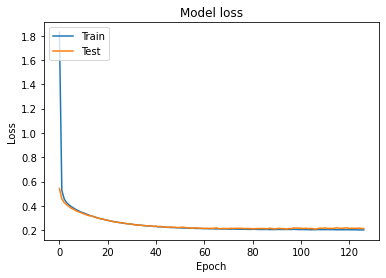

验证集上的最优结果是0.48079273104667664,对应训练轮次是67
create model. feature_dim =2028, label_dim =151
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_242 (Dense)           (None, 256)               519424    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_243 (Dense)           (None, 256)               65792     
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_244 (Dense)           (None, 256)               65792     
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                               

50/50 [==============================] - 1s 10ms/step - loss: 0.2422 - JI: 0.4293 - val_loss: 0.2420 - val_JI: 0.4248
Epoch 50/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2414 - JI: 0.4295 - val_loss: 0.2413 - val_JI: 0.4243
Epoch 51/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2407 - JI: 0.4296 - val_loss: 0.2406 - val_JI: 0.4252
Epoch 52/500
50/50 [==============================] - 0s 10ms/step - loss: 0.2400 - JI: 0.4293 - val_loss: 0.2399 - val_JI: 0.4244
Epoch 53/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2394 - JI: 0.4296 - val_loss: 0.2394 - val_JI: 0.4244
Epoch 54/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2388 - JI: 0.4296 - val_loss: 0.2389 - val_JI: 0.4244
Epoch 55/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2383 - JI: 0.4296 - val_loss: 0.2384 - val_JI: 0.4235
Epoch 56/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2379 - JI: 0.4292 -

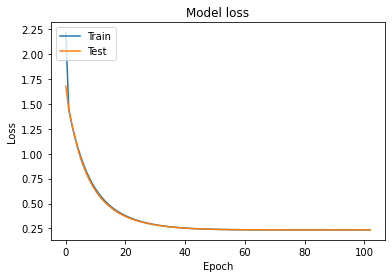

验证集上的最优结果是0.42558467388153076,对应训练轮次是21
create model. feature_dim =2028, label_dim =151
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_248 (Dense)           (None, 256)               519424    
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_249 (Dense)           (None, 256)               65792     
                                                                 
 dense_250 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 10ms/step - loss: 2.2317 - JI: 0.29

50/50 [==============================] - 0s 7ms/step - loss: 0.2236 - JI: 0.4723 - val_loss: 0.2273 - val_JI: 0.4598
Epoch 57/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2229 - JI: 0.4730 - val_loss: 0.2294 - val_JI: 0.4523
Epoch 58/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2235 - JI: 0.4742 - val_loss: 0.2307 - val_JI: 0.4516
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2231 - JI: 0.4729 - val_loss: 0.2262 - val_JI: 0.4565
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2209 - JI: 0.4742 - val_loss: 0.2309 - val_JI: 0.4443
Epoch 61/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2197 - JI: 0.4752 - val_loss: 0.2277 - val_JI: 0.4523
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2200 - JI: 0.4743 - val_loss: 0.2275 - val_JI: 0.4489
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2191 - JI: 0.4753 - val_los

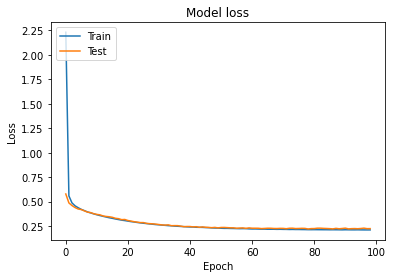

验证集上的最优结果是0.4637768566608429,对应训练轮次是44
create model. feature_dim =2028, label_dim =151
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_251 (Dense)           (None, 256)               519424    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_252 (Dense)           (None, 256)               65792     
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_253 (Dense)           (None, 256)               65792     
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                

50/50 [==============================] - 1s 10ms/step - loss: 0.2520 - JI: 0.4296 - val_loss: 0.2513 - val_JI: 0.4252
Epoch 50/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2503 - JI: 0.4295 - val_loss: 0.2497 - val_JI: 0.4252
Epoch 51/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2488 - JI: 0.4294 - val_loss: 0.2483 - val_JI: 0.4252
Epoch 52/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2474 - JI: 0.4298 - val_loss: 0.2470 - val_JI: 0.4252
Epoch 53/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2462 - JI: 0.4295 - val_loss: 0.2458 - val_JI: 0.4252
Epoch 54/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2450 - JI: 0.4294 - val_loss: 0.2447 - val_JI: 0.4252
Epoch 55/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2440 - JI: 0.4295 - val_loss: 0.2436 - val_JI: 0.4252
Epoch 56/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2430 - JI: 0.4292 -

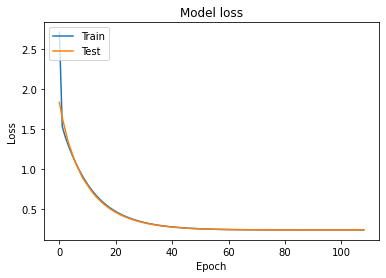

验证集上的最优结果是0.425189346075058,对应训练轮次是33


[0.5207446217536926,
 0.48857381939888,
 0.5105302929878235,
 0.4501694142818451,
 0.5031652450561523,
 0.4501384198665619,
 0.48079273104667664,
 0.42558467388153076,
 0.4637768566608429,
 0.425189346075058]

In [33]:
results = []
# 调hidden_layer_dropout
for dropout_rate in dropout_rate_list:
    results.append(train_DNN(X_train,y_train,X_test,y_test,use_kernel_regularizer = True,kernel_regularizer = tf.keras.regularizers.l1(0.0001),hidden_layer_dropout=True, dropout_rate=dropout_rate))
    results.append(train_DNN(X_train,y_train,X_test,y_test,hidden_layer_num = 4,use_kernel_regularizer = True,kernel_regularizer = tf.keras.regularizers.l1(0.0001),hidden_layer_dropout=True, dropout_rate=dropout_rate))
results

create model. feature_dim =2028, label_dim =151
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_257 (Dense)           (None, 256)               519424    
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_258 (Dense)           (None, 256)               65792     
                                                                 
 dense_259 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.4801 - JI: 0.3015 - val_loss: 0.2964 - val_JI: 0.3867
Ep

50/50 [==============================] - 0s 7ms/step - loss: 0.1866 - JI: 0.5259 - val_loss: 0.1950 - val_JI: 0.5089
Epoch 57/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1860 - JI: 0.5278 - val_loss: 0.1961 - val_JI: 0.5069
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1858 - JI: 0.5290 - val_loss: 0.1950 - val_JI: 0.5115
Epoch 59/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1860 - JI: 0.5273 - val_loss: 0.1952 - val_JI: 0.5166
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1864 - JI: 0.5269 - val_loss: 0.1945 - val_JI: 0.5135
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1849 - JI: 0.5298 - val_loss: 0.1958 - val_JI: 0.5167
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1848 - JI: 0.5303 - val_loss: 0.1974 - val_JI: 0.5155
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1853 - JI: 0.5297 - val_los

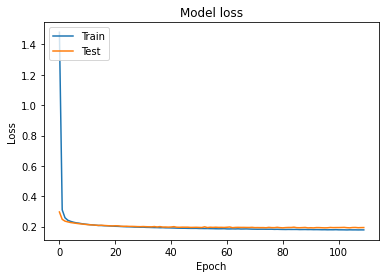

验证集上的最优结果是0.5210317373275757,对应训练轮次是105
create model. feature_dim =2028, label_dim =151
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_260 (Dense)           (None, 256)               519424    
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense_261 (Dense)           (None, 256)               65792     
                                                                 
 dropout_27 (Dropout)        (None, 256)               0         
                                                                 
 dense_262 (Dense)           (None, 256)               65792     
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                               

50/50 [==============================] - 1s 13ms/step - loss: 0.1933 - JI: 0.5112 - val_loss: 0.1990 - val_JI: 0.4937
Epoch 50/500
50/50 [==============================] - 1s 12ms/step - loss: 0.1920 - JI: 0.5142 - val_loss: 0.1986 - val_JI: 0.5007
Epoch 51/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1914 - JI: 0.5153 - val_loss: 0.1976 - val_JI: 0.5007
Epoch 52/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1919 - JI: 0.5137 - val_loss: 0.1963 - val_JI: 0.5009
Epoch 53/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1912 - JI: 0.5153 - val_loss: 0.1992 - val_JI: 0.4964
Epoch 54/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1908 - JI: 0.5169 - val_loss: 0.1964 - val_JI: 0.5001
Epoch 55/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1900 - JI: 0.5186 - val_loss: 0.1952 - val_JI: 0.5046
Epoch 56/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1897 - JI: 0.5187 -

50/50 [==============================] - 0s 10ms/step - loss: 0.1763 - JI: 0.5465 - val_loss: 0.1919 - val_JI: 0.5158
Epoch 112/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1760 - JI: 0.5470 - val_loss: 0.1921 - val_JI: 0.5115
Epoch 113/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1753 - JI: 0.5481 - val_loss: 0.1919 - val_JI: 0.5133
Epoch 114/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1750 - JI: 0.5481 - val_loss: 0.1931 - val_JI: 0.5099
Epoch 115/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1757 - JI: 0.5470 - val_loss: 0.1926 - val_JI: 0.5099
Epoch 116/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1755 - JI: 0.5471 - val_loss: 0.1933 - val_JI: 0.5146
Epoch 117/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1752 - JI: 0.5479 - val_loss: 0.1931 - val_JI: 0.5141
Epoch 118/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1751 - JI: 0

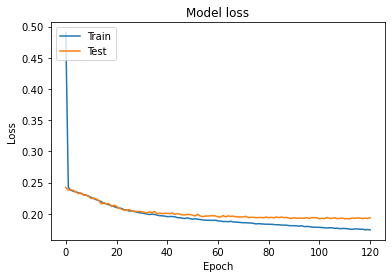

验证集上的最优结果是0.5166717767715454,对应训练轮次是108
create model. feature_dim =2028, label_dim =151
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_266 (Dense)           (None, 256)               519424    
                                                                 
 dropout_30 (Dropout)        (None, 256)               0         
                                                                 
 dense_267 (Dense)           (None, 256)               65792     
                                                                 
 dense_268 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.4762 - JI: 0.306

50/50 [==============================] - 0s 7ms/step - loss: 0.1961 - JI: 0.5070 - val_loss: 0.1976 - val_JI: 0.5075
Epoch 57/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1958 - JI: 0.5070 - val_loss: 0.2010 - val_JI: 0.4987
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1977 - JI: 0.5038 - val_loss: 0.1989 - val_JI: 0.5012
Epoch 59/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1959 - JI: 0.5077 - val_loss: 0.1994 - val_JI: 0.4977
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1951 - JI: 0.5081 - val_loss: 0.1988 - val_JI: 0.5024
Epoch 61/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1945 - JI: 0.5093 - val_loss: 0.1987 - val_JI: 0.5086
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1937 - JI: 0.5114 - val_loss: 0.1969 - val_JI: 0.5056
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1934 - JI: 0.5122 - val_los

Epoch 119/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1875 - JI: 0.5236 - val_loss: 0.1961 - val_JI: 0.5110
Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1880 - JI: 0.5228 - val_loss: 0.1975 - val_JI: 0.5019
Epoch 121/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1883 - JI: 0.5216 - val_loss: 0.1951 - val_JI: 0.5133
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1880 - JI: 0.5231 - val_loss: 0.1955 - val_JI: 0.5075
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1909 - JI: 0.5163 - val_loss: 0.1971 - val_JI: 0.5139
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1899 - JI: 0.5191 - val_loss: 0.1958 - val_JI: 0.5135
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1887 - JI: 0.5209 - val_loss: 0.1969 - val_JI: 0.5062
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1882 -

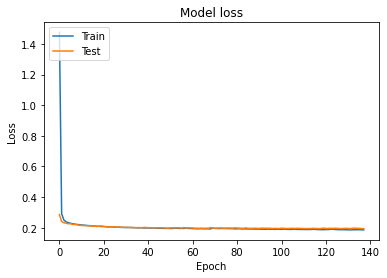

验证集上的最优结果是0.5184032320976257,对应训练轮次是132
create model. feature_dim =2028, label_dim =151
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_269 (Dense)           (None, 256)               519424    
                                                                 
 dropout_31 (Dropout)        (None, 256)               0         
                                                                 
 dense_270 (Dense)           (None, 256)               65792     
                                                                 
 dropout_32 (Dropout)        (None, 256)               0         
                                                                 
 dense_271 (Dense)           (None, 256)               65792     
                                                                 
 dropout_33 (Dropout)        (None, 256)               0         
                               

50/50 [==============================] - 1s 11ms/step - loss: 0.2027 - JI: 0.4924 - val_loss: 0.2012 - val_JI: 0.4918
Epoch 50/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2024 - JI: 0.4926 - val_loss: 0.2017 - val_JI: 0.4906
Epoch 51/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2020 - JI: 0.4938 - val_loss: 0.2019 - val_JI: 0.4886
Epoch 52/500
50/50 [==============================] - 0s 10ms/step - loss: 0.2019 - JI: 0.4943 - val_loss: 0.2011 - val_JI: 0.4902
Epoch 53/500
50/50 [==============================] - 0s 10ms/step - loss: 0.2016 - JI: 0.4946 - val_loss: 0.2015 - val_JI: 0.4906
Epoch 54/500
50/50 [==============================] - 0s 10ms/step - loss: 0.2010 - JI: 0.4953 - val_loss: 0.2015 - val_JI: 0.4918
Epoch 55/500
50/50 [==============================] - 0s 10ms/step - loss: 0.2009 - JI: 0.4962 - val_loss: 0.2018 - val_JI: 0.4881
Epoch 56/500
50/50 [==============================] - 1s 12ms/step - loss: 0.2006 - JI: 0.4968 -

50/50 [==============================] - 0s 10ms/step - loss: 0.1943 - JI: 0.5088 - val_loss: 0.1973 - val_JI: 0.4968
Epoch 112/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1950 - JI: 0.5076 - val_loss: 0.1978 - val_JI: 0.4998
Epoch 113/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1945 - JI: 0.5080 - val_loss: 0.1978 - val_JI: 0.4999
Epoch 114/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1940 - JI: 0.5089 - val_loss: 0.1972 - val_JI: 0.5024
Epoch 115/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1950 - JI: 0.5085 - val_loss: 0.1970 - val_JI: 0.5022
Epoch 116/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1944 - JI: 0.5083 - val_loss: 0.1969 - val_JI: 0.5007
Epoch 117/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1940 - JI: 0.5095 - val_loss: 0.1987 - val_JI: 0.4988
Epoch 118/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1936 - JI: 0.

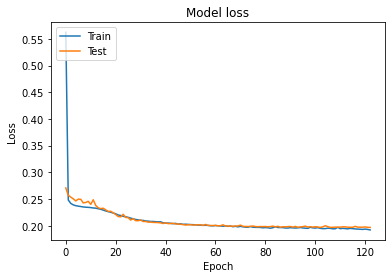

验证集上的最优结果是0.5037513375282288,对应训练轮次是118
create model. feature_dim =2028, label_dim =151
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_275 (Dense)           (None, 256)               519424    
                                                                 
 dropout_35 (Dropout)        (None, 256)               0         
                                                                 
 dense_276 (Dense)           (None, 256)               65792     
                                                                 
 dense_277 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.4844 - JI: 0.302

50/50 [==============================] - 0s 7ms/step - loss: 0.2062 - JI: 0.4858 - val_loss: 0.2106 - val_JI: 0.4798
Epoch 57/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2056 - JI: 0.4865 - val_loss: 0.2096 - val_JI: 0.4828
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2058 - JI: 0.4859 - val_loss: 0.2078 - val_JI: 0.4858
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2053 - JI: 0.4867 - val_loss: 0.2090 - val_JI: 0.4790
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2058 - JI: 0.4859 - val_loss: 0.2116 - val_JI: 0.4714
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2045 - JI: 0.4894 - val_loss: 0.2089 - val_JI: 0.4837
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2046 - JI: 0.4882 - val_loss: 0.2074 - val_JI: 0.4877
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2047 - JI: 0.4884 - val_los

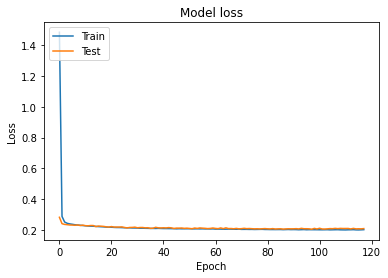

验证集上的最优结果是0.49222734570503235,对应训练轮次是98
create model. feature_dim =2028, label_dim =151
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_278 (Dense)           (None, 256)               519424    
                                                                 
 dropout_36 (Dropout)        (None, 256)               0         
                                                                 
 dense_279 (Dense)           (None, 256)               65792     
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                                 
 dense_280 (Dense)           (None, 256)               65792     
                                                                 
 dropout_38 (Dropout)        (None, 256)               0         
                               

Epoch 50/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2167 - JI: 0.4646 - val_loss: 0.2142 - val_JI: 0.4605
Epoch 51/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2171 - JI: 0.4632 - val_loss: 0.2148 - val_JI: 0.4609
Epoch 52/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2167 - JI: 0.4640 - val_loss: 0.2153 - val_JI: 0.4589
Epoch 53/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2163 - JI: 0.4650 - val_loss: 0.2146 - val_JI: 0.4618
Epoch 54/500
50/50 [==============================] - 0s 10ms/step - loss: 0.2162 - JI: 0.4650 - val_loss: 0.2147 - val_JI: 0.4612
Epoch 55/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2154 - JI: 0.4665 - val_loss: 0.2152 - val_JI: 0.4578
Epoch 56/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2158 - JI: 0.4655 - val_loss: 0.2127 - val_JI: 0.4653
Epoch 57/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2159 - JI: 0.

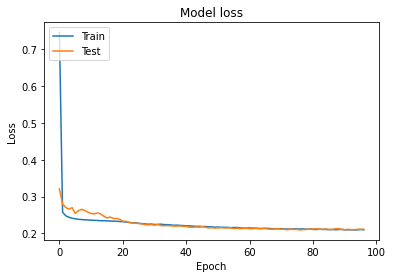

验证集上的最优结果是0.47499266266822815,对应训练轮次是78
create model. feature_dim =2028, label_dim =151
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_284 (Dense)           (None, 256)               519424    
                                                                 
 dropout_40 (Dropout)        (None, 256)               0         
                                                                 
 dense_285 (Dense)           (None, 256)               65792     
                                                                 
 dense_286 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 10ms/step - loss: 1.6892 - JI: 0.29

50/50 [==============================] - 0s 7ms/step - loss: 0.2123 - JI: 0.4723 - val_loss: 0.2234 - val_JI: 0.4446
Epoch 57/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2120 - JI: 0.4728 - val_loss: 0.2295 - val_JI: 0.4297
Epoch 58/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2121 - JI: 0.4726 - val_loss: 0.2247 - val_JI: 0.4424
Epoch 59/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2116 - JI: 0.4736 - val_loss: 0.2267 - val_JI: 0.4358
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2120 - JI: 0.4726 - val_loss: 0.2250 - val_JI: 0.4418
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2114 - JI: 0.4733 - val_loss: 0.2235 - val_JI: 0.4429
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2120 - JI: 0.4733 - val_loss: 0.2310 - val_JI: 0.4239
Epoch 63/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2116 - JI: 0.4736 - val_los

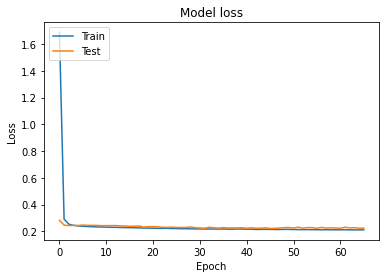

验证集上的最优结果是0.4536449611186981,对应训练轮次是32
create model. feature_dim =2028, label_dim =151
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_287 (Dense)           (None, 256)               519424    
                                                                 
 dropout_41 (Dropout)        (None, 256)               0         
                                                                 
 dense_288 (Dense)           (None, 256)               65792     
                                                                 
 dropout_42 (Dropout)        (None, 256)               0         
                                                                 
 dense_289 (Dense)           (None, 256)               65792     
                                                                 
 dropout_43 (Dropout)        (None, 256)               0         
                                

50/50 [==============================] - 1s 11ms/step - loss: 0.2257 - JI: 0.4477 - val_loss: 0.2263 - val_JI: 0.4385
Epoch 50/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2257 - JI: 0.4475 - val_loss: 0.2259 - val_JI: 0.4379
Epoch 51/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2256 - JI: 0.4479 - val_loss: 0.2259 - val_JI: 0.4373
Epoch 52/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2256 - JI: 0.4478 - val_loss: 0.2255 - val_JI: 0.4418
Epoch 53/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2250 - JI: 0.4489 - val_loss: 0.2248 - val_JI: 0.4431
Epoch 54/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2251 - JI: 0.4488 - val_loss: 0.2271 - val_JI: 0.4340
Epoch 55/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2249 - JI: 0.4490 - val_loss: 0.2272 - val_JI: 0.4342
Epoch 56/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2250 - JI: 0.4484 -

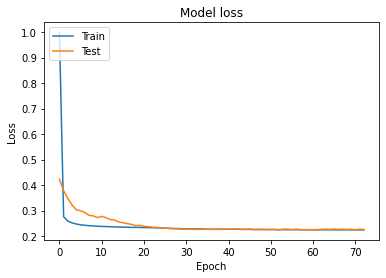

验证集上的最优结果是0.44305431842803955,对应训练轮次是53
create model. feature_dim =2028, label_dim =151
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_293 (Dense)           (None, 256)               519424    
                                                                 
 dropout_45 (Dropout)        (None, 256)               0         
                                                                 
 dense_294 (Dense)           (None, 256)               65792     
                                                                 
 dense_295 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 10ms/step - loss: 2.0739 - JI: 0.28

50/50 [==============================] - 0s 7ms/step - loss: 0.2168 - JI: 0.4626 - val_loss: 0.2372 - val_JI: 0.4206
Epoch 57/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2175 - JI: 0.4617 - val_loss: 0.2384 - val_JI: 0.4197


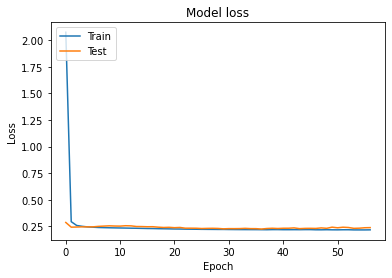

验证集上的最优结果是0.444248765707016,对应训练轮次是30
create model. feature_dim =2028, label_dim =151
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_296 (Dense)           (None, 256)               519424    
                                                                 
 dropout_46 (Dropout)        (None, 256)               0         
                                                                 
 dense_297 (Dense)           (None, 256)               65792     
                                                                 
 dropout_47 (Dropout)        (None, 256)               0         
                                                                 
 dense_298 (Dense)           (None, 256)               65792     
                                                                 
 dropout_48 (Dropout)        (None, 256)               0         
                                 

50/50 [==============================] - 1s 11ms/step - loss: 0.2287 - JI: 0.4410 - val_loss: 0.2273 - val_JI: 0.4373
Epoch 50/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2281 - JI: 0.4431 - val_loss: 0.2272 - val_JI: 0.4389
Epoch 51/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2279 - JI: 0.4440 - val_loss: 0.2269 - val_JI: 0.4390
Epoch 52/500
50/50 [==============================] - 0s 10ms/step - loss: 0.2278 - JI: 0.4436 - val_loss: 0.2288 - val_JI: 0.4312
Epoch 53/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2282 - JI: 0.4424 - val_loss: 0.2283 - val_JI: 0.4376
Epoch 54/500
50/50 [==============================] - 0s 10ms/step - loss: 0.2280 - JI: 0.4433 - val_loss: 0.2273 - val_JI: 0.4357
Epoch 55/500
50/50 [==============================] - 0s 10ms/step - loss: 0.2279 - JI: 0.4430 - val_loss: 0.2268 - val_JI: 0.4409
Epoch 56/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2277 - JI: 0.4439 -

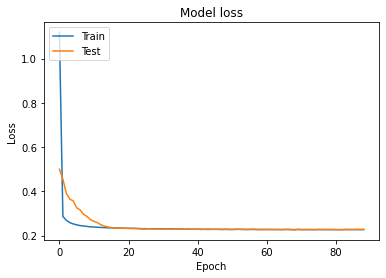

验证集上的最优结果是0.44485345482826233,对应训练轮次是69


[0.5210317373275757,
 0.5166717767715454,
 0.5184032320976257,
 0.5037513375282288,
 0.49222734570503235,
 0.47499266266822815,
 0.4536449611186981,
 0.44305431842803955,
 0.444248765707016,
 0.44485345482826233]

In [34]:
results = []
# 调hidden_layer_dropout,不用正则化
for dropout_rate in dropout_rate_list:
    results.append(train_DNN(X_train,y_train,X_test,y_test,kernel_regularizer = tf.keras.regularizers.l1(0.0001),hidden_layer_dropout=True, dropout_rate=dropout_rate))
    results.append(train_DNN(X_train,y_train,X_test,y_test,hidden_layer_num = 4,kernel_regularizer = tf.keras.regularizers.l1(0.0001),hidden_layer_dropout=True, dropout_rate=dropout_rate))
results

create model. feature_dim =2028, label_dim =151
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_50 (Dropout)        (None, 2028)              0         
                                                                 
 dense_302 (Dense)           (None, 256)               519424    
                                                                 
 dense_303 (Dense)           (None, 151)               38807     
                                                                 
Total params: 558,231
Trainable params: 558,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 11ms/step - loss: 2.8539 - JI: 0.2999 - val_loss: 0.5600 - val_JI: 0.3650
Epoch 2/500
50/50 [==============================] - 0s 9ms/step - loss: 0.5460 - JI: 0.3406 - val_loss: 0.3449 - val_JI: 0.4016
Epoc

50/50 [==============================] - 0s 9ms/step - loss: 0.1792 - JI: 0.5476 - val_loss: 0.1949 - val_JI: 0.5182
Epoch 58/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1791 - JI: 0.5485 - val_loss: 0.1970 - val_JI: 0.5155
Epoch 59/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1784 - JI: 0.5494 - val_loss: 0.1957 - val_JI: 0.5148
Epoch 60/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1784 - JI: 0.5501 - val_loss: 0.1950 - val_JI: 0.5156
Epoch 61/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1774 - JI: 0.5522 - val_loss: 0.1978 - val_JI: 0.5047
Epoch 62/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1770 - JI: 0.5526 - val_loss: 0.1976 - val_JI: 0.5053
Epoch 63/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1769 - JI: 0.5524 - val_loss: 0.1979 - val_JI: 0.5145
Epoch 64/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1777 - JI: 0.5510 - val_los

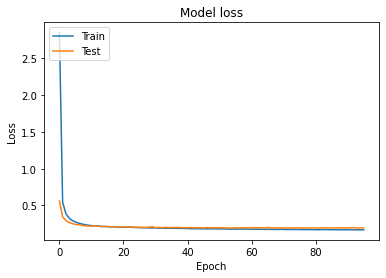

验证集上的最优结果是0.5234407186508179,对应训练轮次是71
create model. feature_dim =2028, label_dim =151
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_51 (Dropout)        (None, 2028)              0         
                                                                 
 dense_304 (Dense)           (None, 256)               519424    
                                                                 
 dense_305 (Dense)           (None, 256)               65792     
                                                                 
 dense_306 (Dense)           (None, 256)               65792     
                                                                 
 dense_307 (Dense)           (None, 256)               65792     
                                                                 
 dense_308 (Dense)           (None, 151)               38807     
                                

50/50 [==============================] - 1s 10ms/step - loss: 0.1853 - JI: 0.5308 - val_loss: 0.1934 - val_JI: 0.5114
Epoch 54/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1847 - JI: 0.5320 - val_loss: 0.1921 - val_JI: 0.5181
Epoch 55/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1843 - JI: 0.5331 - val_loss: 0.1917 - val_JI: 0.5137
Epoch 56/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1844 - JI: 0.5327 - val_loss: 0.1922 - val_JI: 0.5134
Epoch 57/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1835 - JI: 0.5343 - val_loss: 0.1938 - val_JI: 0.5088
Epoch 58/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1834 - JI: 0.5349 - val_loss: 0.1911 - val_JI: 0.5180
Epoch 59/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1832 - JI: 0.5355 - val_loss: 0.1922 - val_JI: 0.5184
Epoch 60/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1831 - JI: 0.5354 -

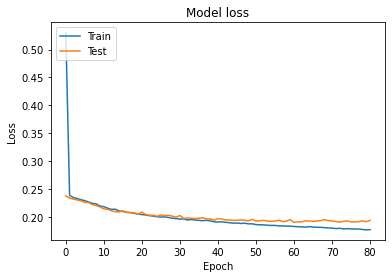

验证集上的最优结果是0.5217095017433167,对应训练轮次是80
create model. feature_dim =2028, label_dim =151
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_52 (Dropout)        (None, 2028)              0         
                                                                 
 dense_309 (Dense)           (None, 256)               519424    
                                                                 
 dense_310 (Dense)           (None, 151)               38807     
                                                                 
Total params: 558,231
Trainable params: 558,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 11ms/step - loss: 2.3126 - JI: 0.3001 - val_loss: 0.5256 - val_JI: 0.3680
Epoch 2/500
50/50 [==============================] - 1s 10ms/step - loss: 0.5528 - JI: 0.3370 

50/50 [==============================] - 0s 9ms/step - loss: 0.1924 - JI: 0.5198 - val_loss: 0.1958 - val_JI: 0.5100
Epoch 58/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1920 - JI: 0.5214 - val_loss: 0.1961 - val_JI: 0.5076
Epoch 59/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1906 - JI: 0.5238 - val_loss: 0.1952 - val_JI: 0.5142
Epoch 60/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1914 - JI: 0.5217 - val_loss: 0.1959 - val_JI: 0.5104
Epoch 61/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1904 - JI: 0.5242 - val_loss: 0.1954 - val_JI: 0.5123
Epoch 62/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1918 - JI: 0.5221 - val_loss: 0.1961 - val_JI: 0.5108
Epoch 63/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1917 - JI: 0.5223 - val_loss: 0.1968 - val_JI: 0.5010
Epoch 64/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1911 - JI: 0.5226 - val_los

Epoch 120/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1823 - JI: 0.5381 - val_loss: 0.1927 - val_JI: 0.5184
Epoch 121/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1822 - JI: 0.5387 - val_loss: 0.1949 - val_JI: 0.5072
Epoch 122/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1834 - JI: 0.5350 - val_loss: 0.1918 - val_JI: 0.5167
Epoch 123/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1815 - JI: 0.5402 - val_loss: 0.1930 - val_JI: 0.5120
Epoch 124/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1817 - JI: 0.5392 - val_loss: 0.1921 - val_JI: 0.5154
Epoch 125/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1817 - JI: 0.5398 - val_loss: 0.1924 - val_JI: 0.5142
Epoch 126/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1812 - JI: 0.5408 - val_loss: 0.1917 - val_JI: 0.5203
Epoch 127/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1820 -

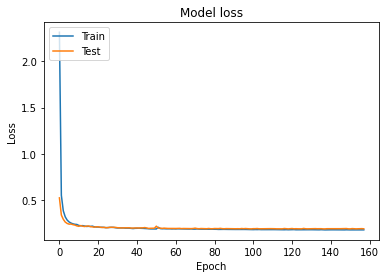

验证集上的最优结果是0.5224828124046326,对应训练轮次是154
create model. feature_dim =2028, label_dim =151
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_53 (Dropout)        (None, 2028)              0         
                                                                 
 dense_311 (Dense)           (None, 256)               519424    
                                                                 
 dense_312 (Dense)           (None, 256)               65792     
                                                                 
 dense_313 (Dense)           (None, 256)               65792     
                                                                 
 dense_314 (Dense)           (None, 256)               65792     
                                                                 
 dense_315 (Dense)           (None, 151)               38807     
                               

50/50 [==============================] - 1s 10ms/step - loss: 0.1928 - JI: 0.5142 - val_loss: 0.1971 - val_JI: 0.4965
Epoch 54/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1934 - JI: 0.5137 - val_loss: 0.1970 - val_JI: 0.5037
Epoch 55/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1933 - JI: 0.5138 - val_loss: 0.1975 - val_JI: 0.5042
Epoch 56/500
50/50 [==============================] - 1s 12ms/step - loss: 0.1921 - JI: 0.5168 - val_loss: 0.1957 - val_JI: 0.5080
Epoch 57/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1918 - JI: 0.5173 - val_loss: 0.1974 - val_JI: 0.5080
Epoch 58/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1929 - JI: 0.5148 - val_loss: 0.1970 - val_JI: 0.4988
Epoch 59/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1920 - JI: 0.5168 - val_loss: 0.1969 - val_JI: 0.5014
Epoch 60/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1908 - JI: 0.5190 -

50/50 [==============================] - 1s 12ms/step - loss: 0.1784 - JI: 0.5437 - val_loss: 0.1930 - val_JI: 0.5100
Epoch 116/500
50/50 [==============================] - 1s 12ms/step - loss: 0.1786 - JI: 0.5433 - val_loss: 0.1910 - val_JI: 0.5141
Epoch 117/500
50/50 [==============================] - 1s 12ms/step - loss: 0.1781 - JI: 0.5429 - val_loss: 0.1897 - val_JI: 0.5204
Epoch 118/500
50/50 [==============================] - 1s 12ms/step - loss: 0.1781 - JI: 0.5434 - val_loss: 0.1899 - val_JI: 0.5161
Epoch 119/500
50/50 [==============================] - 1s 12ms/step - loss: 0.1781 - JI: 0.5433 - val_loss: 0.1908 - val_JI: 0.5185
Epoch 120/500
50/50 [==============================] - 1s 12ms/step - loss: 0.1783 - JI: 0.5431 - val_loss: 0.1906 - val_JI: 0.5164
Epoch 121/500
50/50 [==============================] - 1s 12ms/step - loss: 0.1776 - JI: 0.5448 - val_loss: 0.1889 - val_JI: 0.5237
Epoch 122/500
50/50 [==============================] - 1s 12ms/step - loss: 0.1767 - JI: 0

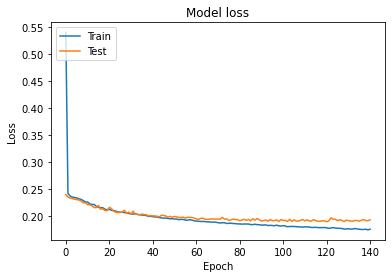

验证集上的最优结果是0.5236868262290955,对应训练轮次是121
create model. feature_dim =2028, label_dim =151
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_54 (Dropout)        (None, 2028)              0         
                                                                 
 dense_316 (Dense)           (None, 256)               519424    
                                                                 
 dense_317 (Dense)           (None, 151)               38807     
                                                                 
Total params: 558,231
Trainable params: 558,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 11ms/step - loss: 2.7061 - JI: 0.2933 - val_loss: 0.5844 - val_JI: 0.3773
Epoch 2/500
50/50 [==============================] - 0s 9ms/step - loss: 0.6079 - JI: 0.3300 

50/50 [==============================] - 0s 8ms/step - loss: 0.1996 - JI: 0.5035 - val_loss: 0.2011 - val_JI: 0.4917
Epoch 58/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2021 - JI: 0.5009 - val_loss: 0.1991 - val_JI: 0.5014
Epoch 59/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1983 - JI: 0.5056 - val_loss: 0.1989 - val_JI: 0.4984
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1982 - JI: 0.5075 - val_loss: 0.1994 - val_JI: 0.4962
Epoch 61/500
50/50 [==============================] - 0s 9ms/step - loss: 0.1982 - JI: 0.5062 - val_loss: 0.1984 - val_JI: 0.4994
Epoch 62/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1984 - JI: 0.5065 - val_loss: 0.1972 - val_JI: 0.5052
Epoch 63/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1987 - JI: 0.5054 - val_loss: 0.1979 - val_JI: 0.5070
Epoch 64/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1974 - JI: 0.5078 - val_los

Epoch 120/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1931 - JI: 0.5166 - val_loss: 0.1961 - val_JI: 0.5111
Epoch 121/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1925 - JI: 0.5171 - val_loss: 0.1962 - val_JI: 0.5041
Epoch 122/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1924 - JI: 0.5178 - val_loss: 0.1950 - val_JI: 0.5096
Epoch 123/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1928 - JI: 0.5160 - val_loss: 0.1954 - val_JI: 0.5128
Epoch 124/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1927 - JI: 0.5165 - val_loss: 0.1953 - val_JI: 0.5131
Epoch 125/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1921 - JI: 0.5179 - val_loss: 0.1953 - val_JI: 0.5115
Epoch 126/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1923 - JI: 0.5169 - val_loss: 0.1954 - val_JI: 0.5117
Epoch 127/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1930 -

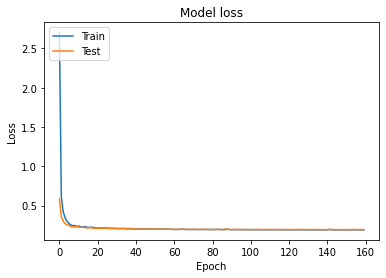

验证集上的最优结果是0.5157912373542786,对应训练轮次是153
create model. feature_dim =2028, label_dim =151
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_55 (Dropout)        (None, 2028)              0         
                                                                 
 dense_318 (Dense)           (None, 256)               519424    
                                                                 
 dense_319 (Dense)           (None, 256)               65792     
                                                                 
 dense_320 (Dense)           (None, 256)               65792     
                                                                 
 dense_321 (Dense)           (None, 256)               65792     
                                                                 
 dense_322 (Dense)           (None, 151)               38807     
                               

50/50 [==============================] - 1s 10ms/step - loss: 0.1990 - JI: 0.5015 - val_loss: 0.2039 - val_JI: 0.4906
Epoch 54/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1980 - JI: 0.5037 - val_loss: 0.2000 - val_JI: 0.4952
Epoch 55/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1984 - JI: 0.5026 - val_loss: 0.1996 - val_JI: 0.4958
Epoch 56/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1983 - JI: 0.5031 - val_loss: 0.2014 - val_JI: 0.4900
Epoch 57/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1979 - JI: 0.5035 - val_loss: 0.1997 - val_JI: 0.4990
Epoch 58/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1981 - JI: 0.5039 - val_loss: 0.2039 - val_JI: 0.4858
Epoch 59/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1971 - JI: 0.5049 - val_loss: 0.2024 - val_JI: 0.4933
Epoch 60/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1973 - JI: 0.5052 -

50/50 [==============================] - 1s 11ms/step - loss: 0.1863 - JI: 0.5265 - val_loss: 0.1949 - val_JI: 0.5047
Epoch 116/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1862 - JI: 0.5271 - val_loss: 0.1965 - val_JI: 0.5012
Epoch 117/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1860 - JI: 0.5273 - val_loss: 0.1969 - val_JI: 0.4977
Epoch 118/500
50/50 [==============================] - 1s 12ms/step - loss: 0.1858 - JI: 0.5284 - val_loss: 0.1965 - val_JI: 0.4967
Epoch 119/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1858 - JI: 0.5287 - val_loss: 0.1998 - val_JI: 0.4912


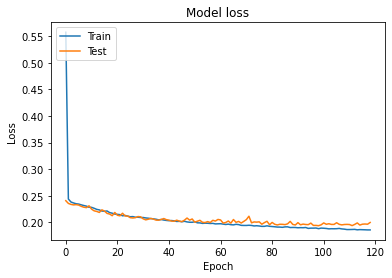

验证集上的最优结果是0.5099995136260986,对应训练轮次是99
create model. feature_dim =2028, label_dim =151
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_56 (Dropout)        (None, 2028)              0         
                                                                 
 dense_323 (Dense)           (None, 256)               519424    
                                                                 
 dense_324 (Dense)           (None, 151)               38807     
                                                                 
Total params: 558,231
Trainable params: 558,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 11ms/step - loss: 2.6558 - JI: 0.2908 - val_loss: 0.6072 - val_JI: 0.3672
Epoch 2/500
50/50 [==============================] - 0s 9ms/step - loss: 0.6202 - JI: 0.3264 -

50/50 [==============================] - 0s 9ms/step - loss: 0.2108 - JI: 0.4830 - val_loss: 0.2072 - val_JI: 0.4774
Epoch 58/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2075 - JI: 0.4859 - val_loss: 0.2053 - val_JI: 0.4862
Epoch 59/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2086 - JI: 0.4846 - val_loss: 0.2056 - val_JI: 0.4818
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2076 - JI: 0.4853 - val_loss: 0.2042 - val_JI: 0.4903
Epoch 61/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2076 - JI: 0.4863 - val_loss: 0.2049 - val_JI: 0.4880
Epoch 62/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2077 - JI: 0.4860 - val_loss: 0.2038 - val_JI: 0.4890
Epoch 63/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2069 - JI: 0.4875 - val_loss: 0.2044 - val_JI: 0.4879
Epoch 64/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2070 - JI: 0.4868 - val_los

Epoch 120/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2029 - JI: 0.4955 - val_loss: 0.2011 - val_JI: 0.4964
Epoch 121/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2030 - JI: 0.4947 - val_loss: 0.2014 - val_JI: 0.4940
Epoch 122/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2033 - JI: 0.4940 - val_loss: 0.2018 - val_JI: 0.4943
Epoch 123/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2035 - JI: 0.4940 - val_loss: 0.2014 - val_JI: 0.4970
Epoch 124/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2027 - JI: 0.4953 - val_loss: 0.2014 - val_JI: 0.4981
Epoch 125/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2028 - JI: 0.4954 - val_loss: 0.2014 - val_JI: 0.4933
Epoch 126/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2028 - JI: 0.4957 - val_loss: 0.2012 - val_JI: 0.4922
Epoch 127/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2029 -

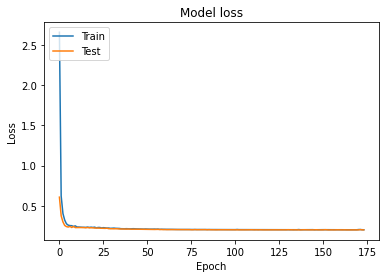

验证集上的最优结果是0.4999997913837433,对应训练轮次是129
create model. feature_dim =2028, label_dim =151
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_57 (Dropout)        (None, 2028)              0         
                                                                 
 dense_325 (Dense)           (None, 256)               519424    
                                                                 
 dense_326 (Dense)           (None, 256)               65792     
                                                                 
 dense_327 (Dense)           (None, 256)               65792     
                                                                 
 dense_328 (Dense)           (None, 256)               65792     
                                                                 
 dense_329 (Dense)           (None, 151)               38807     
                               

50/50 [==============================] - 1s 11ms/step - loss: 0.2044 - JI: 0.4898 - val_loss: 0.2116 - val_JI: 0.4678
Epoch 54/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2032 - JI: 0.4929 - val_loss: 0.2144 - val_JI: 0.4663
Epoch 55/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2032 - JI: 0.4918 - val_loss: 0.2101 - val_JI: 0.4749
Epoch 56/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2031 - JI: 0.4933 - val_loss: 0.2150 - val_JI: 0.4619
Epoch 57/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2033 - JI: 0.4924 - val_loss: 0.2158 - val_JI: 0.4611
Epoch 58/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2029 - JI: 0.4931 - val_loss: 0.2116 - val_JI: 0.4767
Epoch 59/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2025 - JI: 0.4941 - val_loss: 0.2119 - val_JI: 0.4743
Epoch 60/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2024 - JI: 0.4945 -

50/50 [==============================] - 1s 12ms/step - loss: 0.1928 - JI: 0.5136 - val_loss: 0.2010 - val_JI: 0.4890
Epoch 116/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1929 - JI: 0.5138 - val_loss: 0.2008 - val_JI: 0.4906
Epoch 117/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1923 - JI: 0.5146 - val_loss: 0.1996 - val_JI: 0.4942
Epoch 118/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1924 - JI: 0.5149 - val_loss: 0.1991 - val_JI: 0.4981
Epoch 119/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1920 - JI: 0.5149 - val_loss: 0.1974 - val_JI: 0.5015
Epoch 120/500
50/50 [==============================] - 1s 12ms/step - loss: 0.1921 - JI: 0.5157 - val_loss: 0.1997 - val_JI: 0.4922
Epoch 121/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1917 - JI: 0.5160 - val_loss: 0.1992 - val_JI: 0.4923
Epoch 122/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1918 - JI: 0

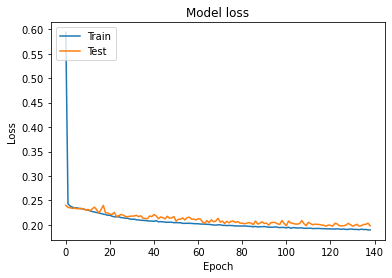

验证集上的最优结果是0.501538097858429,对应训练轮次是119
create model. feature_dim =2028, label_dim =151
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_58 (Dropout)        (None, 2028)              0         
                                                                 
 dense_330 (Dense)           (None, 256)               519424    
                                                                 
 dense_331 (Dense)           (None, 151)               38807     
                                                                 
Total params: 558,231
Trainable params: 558,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 11ms/step - loss: 3.0958 - JI: 0.2934 - val_loss: 0.6957 - val_JI: 0.3406
Epoch 2/500
50/50 [==============================] - 0s 9ms/step - loss: 0.6850 - JI: 0.3230 -

50/50 [==============================] - 0s 9ms/step - loss: 0.2074 - JI: 0.4879 - val_loss: 0.2027 - val_JI: 0.4934
Epoch 58/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2081 - JI: 0.4867 - val_loss: 0.2028 - val_JI: 0.4986
Epoch 59/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2068 - JI: 0.4888 - val_loss: 0.2027 - val_JI: 0.4974
Epoch 60/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2066 - JI: 0.4895 - val_loss: 0.2023 - val_JI: 0.4931
Epoch 61/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2065 - JI: 0.4897 - val_loss: 0.2020 - val_JI: 0.4964
Epoch 62/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2056 - JI: 0.4913 - val_loss: 0.2023 - val_JI: 0.4979
Epoch 63/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2072 - JI: 0.4896 - val_loss: 0.2007 - val_JI: 0.4990
Epoch 64/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2050 - JI: 0.4923 - val_los

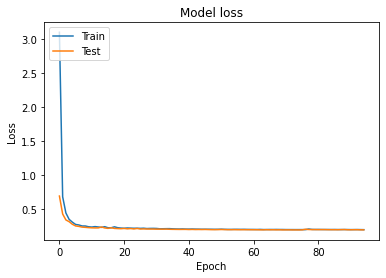

验证集上的最优结果是0.5040981769561768,对应训练轮次是74
create model. feature_dim =2028, label_dim =151
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_59 (Dropout)        (None, 2028)              0         
                                                                 
 dense_332 (Dense)           (None, 256)               519424    
                                                                 
 dense_333 (Dense)           (None, 256)               65792     
                                                                 
 dense_334 (Dense)           (None, 256)               65792     
                                                                 
 dense_335 (Dense)           (None, 256)               65792     
                                                                 
 dense_336 (Dense)           (None, 151)               38807     
                                

50/50 [==============================] - 1s 11ms/step - loss: 0.2083 - JI: 0.4810 - val_loss: 0.2194 - val_JI: 0.4539
Epoch 54/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2082 - JI: 0.4823 - val_loss: 0.2178 - val_JI: 0.4655
Epoch 55/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2075 - JI: 0.4837 - val_loss: 0.2208 - val_JI: 0.4542
Epoch 56/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2070 - JI: 0.4845 - val_loss: 0.2248 - val_JI: 0.4398
Epoch 57/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2081 - JI: 0.4824 - val_loss: 0.2183 - val_JI: 0.4604
Epoch 58/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2066 - JI: 0.4853 - val_loss: 0.2149 - val_JI: 0.4678
Epoch 59/500
50/50 [==============================] - 1s 11ms/step - loss: 0.2065 - JI: 0.4854 - val_loss: 0.2164 - val_JI: 0.4639
Epoch 60/500
50/50 [==============================] - 1s 10ms/step - loss: 0.2064 - JI: 0.4862 -

50/50 [==============================] - 1s 10ms/step - loss: 0.1973 - JI: 0.5046 - val_loss: 0.2114 - val_JI: 0.4712
Epoch 116/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1974 - JI: 0.5043 - val_loss: 0.2089 - val_JI: 0.4823
Epoch 117/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1973 - JI: 0.5043 - val_loss: 0.2034 - val_JI: 0.4932
Epoch 118/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1974 - JI: 0.5041 - val_loss: 0.2045 - val_JI: 0.4870
Epoch 119/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1970 - JI: 0.5056 - val_loss: 0.2089 - val_JI: 0.4792
Epoch 120/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1967 - JI: 0.5062 - val_loss: 0.2071 - val_JI: 0.4858
Epoch 121/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1972 - JI: 0.5043 - val_loss: 0.2040 - val_JI: 0.4906
Epoch 122/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1975 - JI: 0

50/50 [==============================] - 1s 10ms/step - loss: 0.1927 - JI: 0.5137 - val_loss: 0.1975 - val_JI: 0.4955
Epoch 178/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1928 - JI: 0.5128 - val_loss: 0.1983 - val_JI: 0.4970
Epoch 179/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1927 - JI: 0.5135 - val_loss: 0.2037 - val_JI: 0.4820
Epoch 180/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1928 - JI: 0.5130 - val_loss: 0.1974 - val_JI: 0.4997
Epoch 181/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1927 - JI: 0.5132 - val_loss: 0.1961 - val_JI: 0.5042
Epoch 182/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1921 - JI: 0.5146 - val_loss: 0.2034 - val_JI: 0.4931
Epoch 183/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1927 - JI: 0.5132 - val_loss: 0.1989 - val_JI: 0.4965
Epoch 184/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1923 - JI: 0

50/50 [==============================] - 1s 10ms/step - loss: 0.1900 - JI: 0.5179 - val_loss: 0.1978 - val_JI: 0.4948
Epoch 240/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1895 - JI: 0.5187 - val_loss: 0.1957 - val_JI: 0.5067
Epoch 241/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1899 - JI: 0.5180 - val_loss: 0.2001 - val_JI: 0.4902
Epoch 242/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1905 - JI: 0.5167 - val_loss: 0.1976 - val_JI: 0.4991
Epoch 243/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1900 - JI: 0.5181 - val_loss: 0.1959 - val_JI: 0.4994
Epoch 244/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1894 - JI: 0.5190 - val_loss: 0.1966 - val_JI: 0.4967
Epoch 245/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1899 - JI: 0.5179 - val_loss: 0.1972 - val_JI: 0.5019
Epoch 246/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1897 - JI: 0

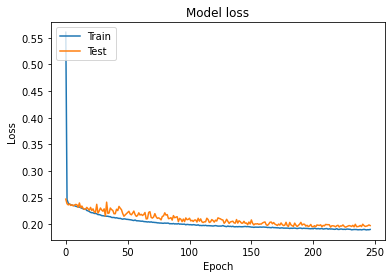

验证集上的最优结果是0.5079396367073059,对应训练轮次是197


[0.5234407186508179,
 0.5217095017433167,
 0.5224828124046326,
 0.5236868262290955,
 0.5157912373542786,
 0.5099995136260986,
 0.4999997913837433,
 0.501538097858429,
 0.5040981769561768,
 0.5079396367073059]

In [35]:
results = []
# 调input_layer_dropout,不用正则化
for dropout_rate in dropout_rate_list:
    results.append(train_DNN(X_train,y_train,X_test,y_test,kernel_regularizer = tf.keras.regularizers.l1(0.0001),input_layer_dropout=True, dropout_rate=dropout_rate))
    results.append(train_DNN(X_train,y_train,X_test,y_test,hidden_layer_num = 4,kernel_regularizer = tf.keras.regularizers.l1(0.0001),input_layer_dropout=True, dropout_rate=dropout_rate))
results

create model. feature_dim =2028, label_dim =151
Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_373 (Dense)           (None, 256)               519424    
                                                                 
 dense_374 (Dense)           (None, 256)               65792     
                                                                 
 dense_375 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.4397 - JI: 0.3274 - val_loss: 0.5399 - val_JI: 0.3855
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.4792 - JI: 0.4080 - val_loss: 0.4379 - val_JI: 0.4128
Epoch

50/50 [==============================] - 0s 6ms/step - loss: 0.2088 - JI: 0.5506 - val_loss: 0.2217 - val_JI: 0.5227
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2078 - JI: 0.5520 - val_loss: 0.2212 - val_JI: 0.5222
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2065 - JI: 0.5524 - val_loss: 0.2187 - val_JI: 0.5239
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2039 - JI: 0.5555 - val_loss: 0.2191 - val_JI: 0.5210
Epoch 61/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2042 - JI: 0.5540 - val_loss: 0.2191 - val_JI: 0.5177
Epoch 62/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2033 - JI: 0.5545 - val_loss: 0.2189 - val_JI: 0.5150
Epoch 63/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2027 - JI: 0.5540 - val_loss: 0.2170 - val_JI: 0.5235
Epoch 64/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2012 - JI: 0.5557 - val_los

Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1752 - JI: 0.5785 - val_loss: 0.2008 - val_JI: 0.5230
Epoch 121/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1751 - JI: 0.5782 - val_loss: 0.1978 - val_JI: 0.5273
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1746 - JI: 0.5799 - val_loss: 0.2016 - val_JI: 0.5222
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1748 - JI: 0.5794 - val_loss: 0.1986 - val_JI: 0.5274
Epoch 124/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1744 - JI: 0.5795 - val_loss: 0.1986 - val_JI: 0.5293
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1747 - JI: 0.5797 - val_loss: 0.2017 - val_JI: 0.5245
Epoch 126/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1746 - JI: 0.5796 - val_loss: 0.2005 - val_JI: 0.5211
Epoch 127/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1738 -

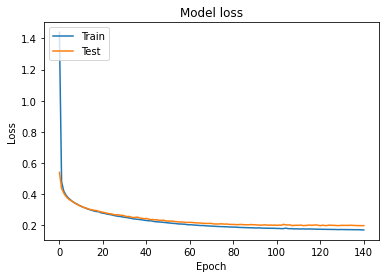

验证集上的最优结果是0.530281662940979,对应训练轮次是129


0.530281662940979

In [43]:
# 保存最优模型
train_DNN(X_train,y_train,X_test,y_test,callbacks_list=[
     keras.callbacks.EarlyStopping(
    monitor='val_loss',
     patience=20,
    ),
    keras.callbacks.ModelCheckpoint(
    filepath=r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\jupyter\model\my_model.h5',
    monitor='val_loss',
    save_best_only=True,
    )
], use_kernel_regularizer = True)

create model. feature_dim =2028, label_dim =151
Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_340 (Dense)           (None, 256)               519424    
                                                                 
 dense_341 (Dense)           (None, 256)               65792     
                                                                 
 dense_342 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.3735 - JI: 0.3084 - val_loss: 0.5354 - val_JI: 0.3272
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.4732 - JI: 0.3464 - val_loss: 0.4342 - val_JI: 0.3377
Epoch

50/50 [==============================] - 0s 7ms/step - loss: 0.2075 - JI: 0.4326 - val_loss: 0.2212 - val_JI: 0.4276
Epoch 58/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2065 - JI: 0.4336 - val_loss: 0.2199 - val_JI: 0.4171
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2053 - JI: 0.4346 - val_loss: 0.2197 - val_JI: 0.3893
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2039 - JI: 0.4347 - val_loss: 0.2175 - val_JI: 0.4016
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2023 - JI: 0.4353 - val_loss: 0.2166 - val_JI: 0.4262
Epoch 62/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2009 - JI: 0.4358 - val_loss: 0.2167 - val_JI: 0.4079
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2011 - JI: 0.4361 - val_loss: 0.2140 - val_JI: 0.4069
Epoch 64/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2002 - JI: 0.4372 - val_los

Epoch 120/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1755 - JI: 0.4574 - val_loss: 0.1982 - val_JI: 0.4332
Epoch 121/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1761 - JI: 0.4581 - val_loss: 0.1996 - val_JI: 0.4137
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1749 - JI: 0.4578 - val_loss: 0.1978 - val_JI: 0.4336
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1749 - JI: 0.4578 - val_loss: 0.2010 - val_JI: 0.4176
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1746 - JI: 0.4578 - val_loss: 0.1989 - val_JI: 0.4495
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1743 - JI: 0.4587 - val_loss: 0.1989 - val_JI: 0.4366
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1744 - JI: 0.4588 - val_loss: 0.1998 - val_JI: 0.4380
Epoch 127/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1746 -

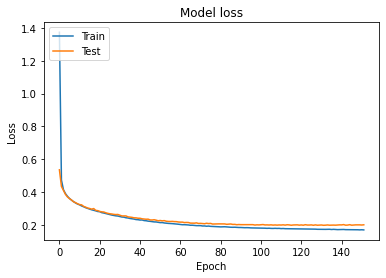

验证集上的最优结果是0.45559394359588623,对应训练轮次是141
create model. feature_dim =2028, label_dim =151
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_343 (Dense)           (None, 256)               519424    
                                                                 
 dense_344 (Dense)           (None, 256)               65792     
                                                                 
 dense_345 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.5528 - JI: 0.3196 - val_loss: 0.5378 - val_JI: 0.3476
Epoch 2/500
50/50 [==============================] - 0s 6ms/step - loss: 0.4790 - JI: 0.3712 

50/50 [==============================] - 0s 7ms/step - loss: 0.2153 - JI: 0.4787 - val_loss: 0.2260 - val_JI: 0.4576
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2134 - JI: 0.4798 - val_loss: 0.2276 - val_JI: 0.4405
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2121 - JI: 0.4803 - val_loss: 0.2256 - val_JI: 0.4608
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2113 - JI: 0.4806 - val_loss: 0.2221 - val_JI: 0.4556
Epoch 61/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2095 - JI: 0.4809 - val_loss: 0.2217 - val_JI: 0.4549
Epoch 62/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2076 - JI: 0.4828 - val_loss: 0.2212 - val_JI: 0.4630
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2077 - JI: 0.4819 - val_loss: 0.2186 - val_JI: 0.4663
Epoch 64/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2061 - JI: 0.4834 - val_los

Epoch 120/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1760 - JI: 0.5053 - val_loss: 0.2009 - val_JI: 0.4559
Epoch 121/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1764 - JI: 0.5056 - val_loss: 0.1979 - val_JI: 0.4745
Epoch 122/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1751 - JI: 0.5059 - val_loss: 0.1981 - val_JI: 0.4690
Epoch 123/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1755 - JI: 0.5056 - val_loss: 0.1990 - val_JI: 0.4716
Epoch 124/500
50/50 [==============================] - 0s 10ms/step - loss: 0.1759 - JI: 0.5056 - val_loss: 0.1997 - val_JI: 0.4585
Epoch 125/500
50/50 [==============================] - 1s 10ms/step - loss: 0.1747 - JI: 0.5069 - val_loss: 0.1996 - val_JI: 0.4854
Epoch 126/500
50/50 [==============================] - 1s 11ms/step - loss: 0.1750 - JI: 0.5067 - val_loss: 0.1985 - val_JI: 0.4716
Epoch 127/500
50/50 [==============================] - 1s 10ms/step - loss: 

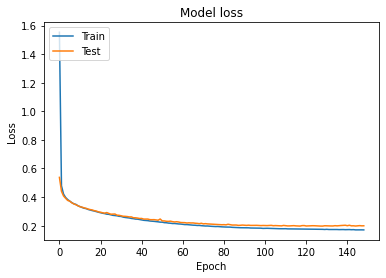

验证集上的最优结果是0.4909115135669708,对应训练轮次是115
create model. feature_dim =2028, label_dim =151
Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_346 (Dense)           (None, 256)               519424    
                                                                 
 dense_347 (Dense)           (None, 256)               65792     
                                                                 
 dense_348 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.6183 - JI: 0.3242 - val_loss: 0.5567 - val_JI: 0.3611
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.4955 - JI: 0.3888 -

50/50 [==============================] - 0s 7ms/step - loss: 0.2127 - JI: 0.5156 - val_loss: 0.2252 - val_JI: 0.4895
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2111 - JI: 0.5161 - val_loss: 0.2255 - val_JI: 0.4782
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2112 - JI: 0.5158 - val_loss: 0.2249 - val_JI: 0.4790
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2101 - JI: 0.5167 - val_loss: 0.2223 - val_JI: 0.4935
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2080 - JI: 0.5185 - val_loss: 0.2230 - val_JI: 0.4837
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2080 - JI: 0.5179 - val_loss: 0.2213 - val_JI: 0.4916
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2065 - JI: 0.5180 - val_loss: 0.2207 - val_JI: 0.4889
Epoch 64/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2047 - JI: 0.5201 - val_los

Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1764 - JI: 0.5406 - val_loss: 0.2012 - val_JI: 0.4960
Epoch 121/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1761 - JI: 0.5399 - val_loss: 0.2000 - val_JI: 0.5001
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1761 - JI: 0.5415 - val_loss: 0.1995 - val_JI: 0.5069
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1748 - JI: 0.5422 - val_loss: 0.2049 - val_JI: 0.5062
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1776 - JI: 0.5398 - val_loss: 0.2020 - val_JI: 0.5126
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1752 - JI: 0.5422 - val_loss: 0.2009 - val_JI: 0.5101
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1750 - JI: 0.5416 - val_loss: 0.1996 - val_JI: 0.5067
Epoch 127/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1744 -

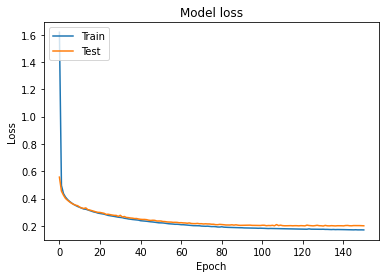

验证集上的最优结果是0.5167117714881897,对应训练轮次是142
create model. feature_dim =2028, label_dim =151
Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_349 (Dense)           (None, 256)               519424    
                                                                 
 dense_350 (Dense)           (None, 256)               65792     
                                                                 
 dense_351 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.3586 - JI: 0.3322 - val_loss: 0.5489 - val_JI: 0.3812
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.4904 - JI: 0.4032 -

50/50 [==============================] - 0s 6ms/step - loss: 0.2108 - JI: 0.5401 - val_loss: 0.2260 - val_JI: 0.5099
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2093 - JI: 0.5414 - val_loss: 0.2317 - val_JI: 0.4892
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2126 - JI: 0.5350 - val_loss: 0.2243 - val_JI: 0.5112
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2085 - JI: 0.5405 - val_loss: 0.2225 - val_JI: 0.5112
Epoch 61/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2065 - JI: 0.5418 - val_loss: 0.2219 - val_JI: 0.5163
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2049 - JI: 0.5437 - val_loss: 0.2229 - val_JI: 0.5151
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2041 - JI: 0.5442 - val_loss: 0.2187 - val_JI: 0.5058
Epoch 64/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2025 - JI: 0.5455 - val_los

Epoch 120/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1747 - JI: 0.5655 - val_loss: 0.2027 - val_JI: 0.5202
Epoch 121/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1747 - JI: 0.5655 - val_loss: 0.2007 - val_JI: 0.5155
Epoch 122/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1746 - JI: 0.5653 - val_loss: 0.2004 - val_JI: 0.5057
Epoch 123/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1744 - JI: 0.5654 - val_loss: 0.1995 - val_JI: 0.5216
Epoch 124/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1733 - JI: 0.5679 - val_loss: 0.1987 - val_JI: 0.5142
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1732 - JI: 0.5676 - val_loss: 0.1994 - val_JI: 0.5191
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1738 - JI: 0.5670 - val_loss: 0.2010 - val_JI: 0.5247
Epoch 127/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1731 -

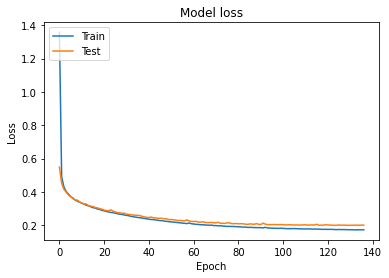

验证集上的最优结果是0.5246708989143372,对应训练轮次是126
create model. feature_dim =2028, label_dim =151
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_352 (Dense)           (None, 256)               519424    
                                                                 
 dense_353 (Dense)           (None, 256)               65792     
                                                                 
 dense_354 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.3916 - JI: 0.3285 - val_loss: 0.5329 - val_JI: 0.3846
Epoch 2/500
50/50 [==============================] - 0s 6ms/step - loss: 0.4734 - JI: 0.4099 -

50/50 [==============================] - 0s 8ms/step - loss: 0.2075 - JI: 0.5476 - val_loss: 0.2201 - val_JI: 0.5178
Epoch 58/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2062 - JI: 0.5480 - val_loss: 0.2188 - val_JI: 0.5194
Epoch 59/500
50/50 [==============================] - 0s 9ms/step - loss: 0.2051 - JI: 0.5497 - val_loss: 0.2184 - val_JI: 0.5138
Epoch 60/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2043 - JI: 0.5493 - val_loss: 0.2198 - val_JI: 0.5163
Epoch 61/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2048 - JI: 0.5475 - val_loss: 0.2172 - val_JI: 0.5156
Epoch 62/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2022 - JI: 0.5509 - val_loss: 0.2159 - val_JI: 0.5184
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2010 - JI: 0.5524 - val_loss: 0.2164 - val_JI: 0.5146
Epoch 64/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2009 - JI: 0.5505 - val_los

Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1757 - JI: 0.5734 - val_loss: 0.1992 - val_JI: 0.5245
Epoch 121/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1744 - JI: 0.5756 - val_loss: 0.2023 - val_JI: 0.5213
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1754 - JI: 0.5740 - val_loss: 0.2004 - val_JI: 0.5222
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1746 - JI: 0.5758 - val_loss: 0.1986 - val_JI: 0.5289
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1741 - JI: 0.5757 - val_loss: 0.1994 - val_JI: 0.5186
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1744 - JI: 0.5744 - val_loss: 0.1990 - val_JI: 0.5235
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1735 - JI: 0.5763 - val_loss: 0.2023 - val_JI: 0.5227
Epoch 127/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1737 -

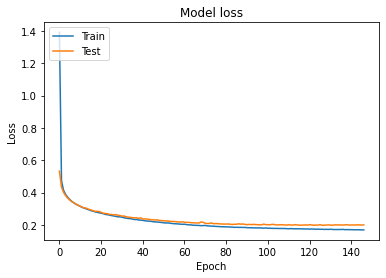

验证集上的最优结果是0.5289099812507629,对应训练轮次是123
create model. feature_dim =2028, label_dim =151
Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_355 (Dense)           (None, 256)               519424    
                                                                 
 dense_356 (Dense)           (None, 256)               65792     
                                                                 
 dense_357 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.3678 - JI: 0.3343 - val_loss: 0.5422 - val_JI: 0.3782
Epoch 2/500
50/50 [==============================] - 0s 6ms/step - loss: 0.4865 - JI: 0.4020 -

50/50 [==============================] - 0s 7ms/step - loss: 0.2136 - JI: 0.5510 - val_loss: 0.2275 - val_JI: 0.5211
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2117 - JI: 0.5545 - val_loss: 0.2260 - val_JI: 0.5217
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2114 - JI: 0.5532 - val_loss: 0.2255 - val_JI: 0.5229
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2104 - JI: 0.5541 - val_loss: 0.2250 - val_JI: 0.5213
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2083 - JI: 0.5556 - val_loss: 0.2262 - val_JI: 0.5122
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2083 - JI: 0.5535 - val_loss: 0.2235 - val_JI: 0.5151
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2064 - JI: 0.5560 - val_loss: 0.2209 - val_JI: 0.5229
Epoch 64/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2043 - JI: 0.5589 - val_los

Epoch 120/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1760 - JI: 0.5817 - val_loss: 0.2016 - val_JI: 0.5253
Epoch 121/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1755 - JI: 0.5823 - val_loss: 0.2017 - val_JI: 0.5274
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1752 - JI: 0.5826 - val_loss: 0.2018 - val_JI: 0.5296
Epoch 123/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1755 - JI: 0.5821 - val_loss: 0.1996 - val_JI: 0.5293
Epoch 124/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1753 - JI: 0.5826 - val_loss: 0.2000 - val_JI: 0.5287
Epoch 125/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1744 - JI: 0.5842 - val_loss: 0.2013 - val_JI: 0.5254
Epoch 126/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1750 - JI: 0.5833 - val_loss: 0.2025 - val_JI: 0.5197
Epoch 127/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1746 -

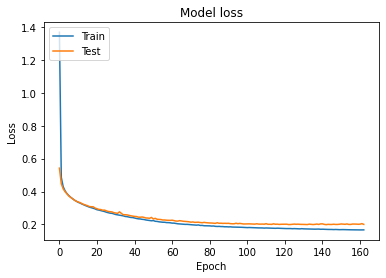

验证集上的最优结果是0.5300465226173401,对应训练轮次是114
create model. feature_dim =2028, label_dim =151
Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_358 (Dense)           (None, 256)               519424    
                                                                 
 dense_359 (Dense)           (None, 256)               65792     
                                                                 
 dense_360 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.4878 - JI: 0.3213 - val_loss: 0.5323 - val_JI: 0.3806
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.4732 - JI: 0.3995 -

50/50 [==============================] - 0s 7ms/step - loss: 0.2091 - JI: 0.5464 - val_loss: 0.2217 - val_JI: 0.5189
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2087 - JI: 0.5462 - val_loss: 0.2222 - val_JI: 0.5123
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2094 - JI: 0.5448 - val_loss: 0.2207 - val_JI: 0.5122
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2061 - JI: 0.5483 - val_loss: 0.2202 - val_JI: 0.5063
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2056 - JI: 0.5468 - val_loss: 0.2172 - val_JI: 0.5189
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2043 - JI: 0.5485 - val_loss: 0.2158 - val_JI: 0.5196
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2041 - JI: 0.5474 - val_loss: 0.2197 - val_JI: 0.5206
Epoch 64/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2028 - JI: 0.5486 - val_los

Epoch 120/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1767 - JI: 0.5718 - val_loss: 0.2008 - val_JI: 0.5193
Epoch 121/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1760 - JI: 0.5744 - val_loss: 0.2008 - val_JI: 0.5279
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1759 - JI: 0.5737 - val_loss: 0.1981 - val_JI: 0.5257
Epoch 123/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1757 - JI: 0.5745 - val_loss: 0.1992 - val_JI: 0.5223
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1759 - JI: 0.5739 - val_loss: 0.1976 - val_JI: 0.5249
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1751 - JI: 0.5754 - val_loss: 0.2005 - val_JI: 0.5147
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1748 - JI: 0.5758 - val_loss: 0.1985 - val_JI: 0.5191
Epoch 127/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1754 -

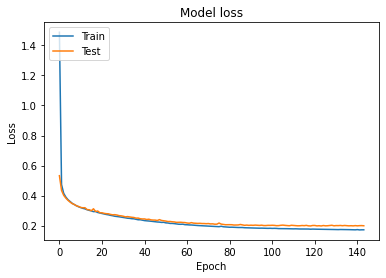

验证集上的最优结果是0.5278928875923157,对应训练轮次是121
create model. feature_dim =2028, label_dim =151
Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_361 (Dense)           (None, 256)               519424    
                                                                 
 dense_362 (Dense)           (None, 256)               65792     
                                                                 
 dense_363 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.6884 - JI: 0.3153 - val_loss: 0.5495 - val_JI: 0.3700
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.4844 - JI: 0.3910 -

50/50 [==============================] - 0s 7ms/step - loss: 0.2105 - JI: 0.5361 - val_loss: 0.2222 - val_JI: 0.5074
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2091 - JI: 0.5379 - val_loss: 0.2208 - val_JI: 0.5087
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2085 - JI: 0.5367 - val_loss: 0.2225 - val_JI: 0.5169
Epoch 60/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2075 - JI: 0.5376 - val_loss: 0.2205 - val_JI: 0.5002
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2064 - JI: 0.5382 - val_loss: 0.2192 - val_JI: 0.5094
Epoch 62/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2055 - JI: 0.5396 - val_loss: 0.2206 - val_JI: 0.5208
Epoch 63/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2038 - JI: 0.5420 - val_loss: 0.2198 - val_JI: 0.5023
Epoch 64/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2034 - JI: 0.5406 - val_los

Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1758 - JI: 0.5676 - val_loss: 0.1996 - val_JI: 0.5253
Epoch 121/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1764 - JI: 0.5665 - val_loss: 0.2003 - val_JI: 0.5122
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1764 - JI: 0.5664 - val_loss: 0.1999 - val_JI: 0.5171
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1752 - JI: 0.5685 - val_loss: 0.1982 - val_JI: 0.5199
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1750 - JI: 0.5689 - val_loss: 0.2002 - val_JI: 0.5078
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1746 - JI: 0.5704 - val_loss: 0.1987 - val_JI: 0.5221
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1747 - JI: 0.5701 - val_loss: 0.1999 - val_JI: 0.5194
Epoch 127/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1745 -

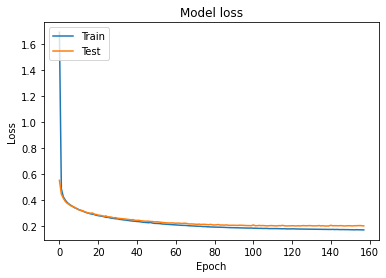

验证集上的最优结果是0.5286913514137268,对应训练轮次是143
create model. feature_dim =2028, label_dim =151
Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_364 (Dense)           (None, 256)               519424    
                                                                 
 dense_365 (Dense)           (None, 256)               65792     
                                                                 
 dense_366 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.3152 - JI: 0.3230 - val_loss: 0.5324 - val_JI: 0.3628
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.4797 - JI: 0.3792 -

50/50 [==============================] - 0s 7ms/step - loss: 0.2109 - JI: 0.5217 - val_loss: 0.2233 - val_JI: 0.4903
Epoch 58/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2086 - JI: 0.5232 - val_loss: 0.2225 - val_JI: 0.4748
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2081 - JI: 0.5229 - val_loss: 0.2219 - val_JI: 0.4767
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2062 - JI: 0.5239 - val_loss: 0.2196 - val_JI: 0.5049
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2054 - JI: 0.5254 - val_loss: 0.2235 - val_JI: 0.4752
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2055 - JI: 0.5247 - val_loss: 0.2194 - val_JI: 0.4974
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2032 - JI: 0.5280 - val_loss: 0.2166 - val_JI: 0.4968
Epoch 64/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2022 - JI: 0.5290 - val_los

Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1755 - JI: 0.5562 - val_loss: 0.2015 - val_JI: 0.5004
Epoch 121/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1762 - JI: 0.5539 - val_loss: 0.2016 - val_JI: 0.5149
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1757 - JI: 0.5552 - val_loss: 0.1998 - val_JI: 0.5083
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1738 - JI: 0.5598 - val_loss: 0.2014 - val_JI: 0.5089
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1754 - JI: 0.5567 - val_loss: 0.2006 - val_JI: 0.5157
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1743 - JI: 0.5587 - val_loss: 0.1992 - val_JI: 0.5104
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1737 - JI: 0.5596 - val_loss: 0.2001 - val_JI: 0.5126
Epoch 127/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1747 -

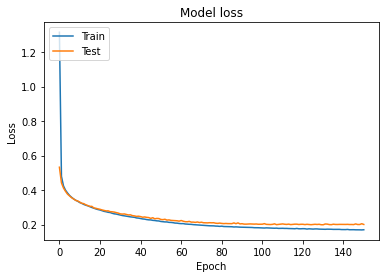

验证集上的最优结果是0.5234087109565735,对应训练轮次是118
create model. feature_dim =2028, label_dim =151
Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_367 (Dense)           (None, 256)               519424    
                                                                 
 dense_368 (Dense)           (None, 256)               65792     
                                                                 
 dense_369 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.4884 - JI: 0.3024 - val_loss: 0.5292 - val_JI: 0.3406
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.4690 - JI: 0.3563 -

50/50 [==============================] - 0s 7ms/step - loss: 0.2079 - JI: 0.5055 - val_loss: 0.2207 - val_JI: 0.4592
Epoch 58/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2060 - JI: 0.5059 - val_loss: 0.2195 - val_JI: 0.4838
Epoch 59/500
50/50 [==============================] - 0s 8ms/step - loss: 0.2051 - JI: 0.5067 - val_loss: 0.2177 - val_JI: 0.4836
Epoch 60/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2037 - JI: 0.5091 - val_loss: 0.2186 - val_JI: 0.4727
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2042 - JI: 0.5073 - val_loss: 0.2175 - val_JI: 0.4867
Epoch 62/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2031 - JI: 0.5077 - val_loss: 0.2210 - val_JI: 0.4345
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2016 - JI: 0.5092 - val_loss: 0.2156 - val_JI: 0.4845
Epoch 64/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2012 - JI: 0.5100 - val_los

Epoch 120/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1752 - JI: 0.5405 - val_loss: 0.1987 - val_JI: 0.4957
Epoch 121/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1750 - JI: 0.5401 - val_loss: 0.2017 - val_JI: 0.4813
Epoch 122/500
50/50 [==============================] - 0s 8ms/step - loss: 0.1746 - JI: 0.5415 - val_loss: 0.1998 - val_JI: 0.4799
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1743 - JI: 0.5410 - val_loss: 0.1999 - val_JI: 0.5026
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1739 - JI: 0.5424 - val_loss: 0.1993 - val_JI: 0.4992
Epoch 125/500
50/50 [==============================] - 0s 6ms/step - loss: 0.1746 - JI: 0.5404 - val_loss: 0.2019 - val_JI: 0.5095
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1741 - JI: 0.5433 - val_loss: 0.2018 - val_JI: 0.4664
Epoch 127/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1732 -

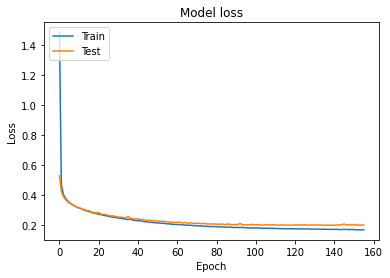

验证集上的最优结果是0.5187286734580994,对应训练轮次是146
create model. feature_dim =2028, label_dim =151
Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_370 (Dense)           (None, 256)               519424    
                                                                 
 dense_371 (Dense)           (None, 256)               65792     
                                                                 
 dense_372 (Dense)           (None, 151)               38807     
                                                                 
Total params: 624,023
Trainable params: 624,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
50/50 [==============================] - 1s 9ms/step - loss: 1.5054 - JI: 0.2994 - val_loss: 0.5299 - val_JI: 0.3354
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 0.4699 - JI: 0.3456 -

50/50 [==============================] - 0s 7ms/step - loss: 0.2094 - JI: 0.4845 - val_loss: 0.2243 - val_JI: 0.4900
Epoch 58/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2080 - JI: 0.4863 - val_loss: 0.2223 - val_JI: 0.4401
Epoch 59/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2068 - JI: 0.4866 - val_loss: 0.2215 - val_JI: 0.4609
Epoch 60/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2058 - JI: 0.4891 - val_loss: 0.2219 - val_JI: 0.4452
Epoch 61/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2054 - JI: 0.4893 - val_loss: 0.2193 - val_JI: 0.4694
Epoch 62/500
50/50 [==============================] - 0s 6ms/step - loss: 0.2040 - JI: 0.4893 - val_loss: 0.2191 - val_JI: 0.4730
Epoch 63/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2025 - JI: 0.4911 - val_loss: 0.2208 - val_JI: 0.4912
Epoch 64/500
50/50 [==============================] - 0s 7ms/step - loss: 0.2020 - JI: 0.4917 - val_los

Epoch 120/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1759 - JI: 0.5193 - val_loss: 0.2036 - val_JI: 0.5000
Epoch 121/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1761 - JI: 0.5196 - val_loss: 0.2011 - val_JI: 0.4686
Epoch 122/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1748 - JI: 0.5210 - val_loss: 0.2003 - val_JI: 0.4679
Epoch 123/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1748 - JI: 0.5223 - val_loss: 0.2010 - val_JI: 0.4810
Epoch 124/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1748 - JI: 0.5218 - val_loss: 0.2021 - val_JI: 0.4932
Epoch 125/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1742 - JI: 0.5233 - val_loss: 0.2009 - val_JI: 0.4766
Epoch 126/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1741 - JI: 0.5227 - val_loss: 0.2018 - val_JI: 0.4904
Epoch 127/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1734 -

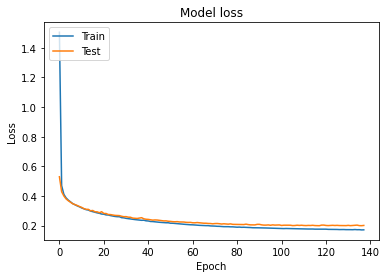

验证集上的最优结果是0.5042608976364136,对应训练轮次是131


In [40]:
# 调节阈值
result_list = []
threshold_list = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
for threshold in threshold_list:
    def JI(y_true, y_pred):
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
    #     K.print_tensor(y_true, message='y_true = ')

        threshold_value = threshold

        y_pred = K.cast(K.greater(y_pred, threshold_value), K.floatx())
    #     K.print_tensor(y_pred, message='y_pred = ')
        fenzi = K.sum(y_true * y_pred, keepdims=True)
        # true_positives_sum = K.sum(true_positives, keepdims=True)
        fenmu = K.sum(K.cast((K.greater(y_true + y_pred, 0.8)), K.floatx()), keepdims=True)

        return K.mean(fenzi / fenmu, axis=-1)
    result_list.append(train_DNN(X_train,y_train,X_test,y_test, metrics=[JI],use_kernel_regularizer = True))

In [41]:
result_list

[0.45559394359588623,
 0.4909115135669708,
 0.5167117714881897,
 0.5246708989143372,
 0.5289099812507629,
 0.5300465226173401,
 0.5278928875923157,
 0.5286913514137268,
 0.5234087109565735,
 0.5187286734580994,
 0.5042608976364136]

In [47]:
import shap
reconstructed_model = keras.models.load_model('C:\\Users\\pinkpigma\\pinkpigma的同步盘\\KDD研二上\\jupyter\\model\\my_model.h5', custom_objects={'JI': JI})


In [50]:
explainer = shap.DeepExplainer(reconstructed_model, X)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


In [51]:
shap_values = explainer.shap_values(X)  # shap 会输出两个矩阵，分别对应着两个标签。两个矩阵内的值为相反数。
shap_values

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: in user code:

    File "D:\ProgramData\Anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 243, in grad_graph  *
        out = self.model(shap_rAnD)
    File "C:\Users\pinkpigma\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "D:\ProgramData\Anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 26, in custom_record_gradient
        out = tf_backprop._record_gradient("shap_"+op_name, inputs, attrs, results)

    AttributeError: Exception encountered when calling layer "dense_373" (type Dense).
    
    module 'tensorflow.python.eager.backprop' has no attribute '_record_gradient'
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(28086, 2028), dtype=float32)
